In [83]:
#!pip install nb_black  --> I don't know what these two does, so I just comment them.
# AM: It formats the code nicely according to best practice - https://github.com/dnanhkhoa/nb_black

<IPython.core.display.Javascript object>

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

#### AM Comments (05.02):
1. Data was not synchronzied as required
2. There are no exchange rates in the dataset
3. Porfolio weights do not sum up to 1
4. Max of returns is x 100 (but this is also the case in the descr. statistics for assignment of last year) - I think this is OK
5. There is a very small misalignment in the descriptive statistics of the data, meaning that we are unable to fully replicate the synchronized dataset, therefore small differences in VaR and ES estimates are also expected (since we do not use the same underlying data).

# QRM First Assignment - Validation

## Import Libraries

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import norm
import scipy as sc
import glob
import matplotlib.pyplot as plt
import os

<IPython.core.display.Javascript object>

## Exploratory Data Analysis

In [64]:
"""Import data"""
prices = pd.read_csv("01_Data/daily_data.csv",)
data = pd.read_csv("01_Data/returns_data.csv")


"""Check format of the datasets"""
print(prices.shape)
print(data.shape)

"""Check if there is null or empty input for any of the datasets."""
print(data.isnull().sum())

(2622, 31)
(2620, 5)
Date          0
SP500       213
STOXX       186
Treas10Y    238
CrudeOil    236
dtype: int64


<IPython.core.display.Javascript object>

In [65]:
"""Split the dataset"""
SP500 = data[["Date", "SP500"]]
STOXX = data[["Date", "STOXX"]]
Treas10Y = data[["Date", "Treas10Y"]]
CrudeOil = data[["Date", "CrudeOil"]]

<IPython.core.display.Javascript object>

## EXTRA CELL - REMOVE

In [66]:
"""Drop missing values"""
asset_val = [SP500, STOXX, Treas10Y, CrudeOil]

for df in asset_val:
    df = df.dropna(axis=0)
    df = df.reset_index(drop=True)
    print(len(df))

"""Ask Jonas why it does not work"""
print(len(SP500))

2407
2434
2382
2384
2620


<IPython.core.display.Javascript object>

In [67]:
SP500 = SP500.dropna(axis=0)
SP500 = SP500.reset_index(drop=True)
STOXX = STOXX.dropna(axis=0)
STOXX = STOXX.reset_index(drop=True)
Treas10Y = Treas10Y.dropna(axis=0)
Treas10Y = Treas10Y.reset_index(drop=True)
CrudeOil = CrudeOil.dropna(axis=0)
CrudeOil = CrudeOil.reset_index(drop=True)
print(len(SP500))
print(len(STOXX))
print(len(Treas10Y))
print(len(CrudeOil))

2407
2434
2382
2384


<IPython.core.display.Javascript object>

In [68]:
"""Synchronize data"""

s1 = set(SP500["Date"])
s2 = set(STOXX["Date"])
s3 = set(Treas10Y["Date"])
s4 = set(CrudeOil["Date"])

d = [x for x in s3 if x in s2 and x in s3 and x in s4]

asset = [s1, s2, s3, s4]

intersec = s1.intersection(s2, s3, s4)
print(len(intersec))
print(len(d))
set(d) == set(intersec)

print("The dates exist in all five dataset: 2284 trading days")

2284
2284
The dates exist in all five dataset: 2284 trading days


<IPython.core.display.Javascript object>

In [69]:
"""  Create new dataframes, keep only the overlapping date-related data"""

new = []
asset = [SP500, STOXX, Treas10Y, CrudeOil]
for item in asset:
    miss = []
    for i in item["Date"]:
        if i not in intersec:
            miss = miss + item.index[item["Date"] == i].tolist()
    item = item.drop(miss)
    item = item.reset_index(drop=True)
    new.append(item)

<IPython.core.display.Javascript object>

In [70]:
""" Assign the dataframe """

SP500_new = new[0]
STOXX_new = new[1]
Treas10Y_new = new[2]
CrudeOil_new = new[3]

asset = [SP500_new, STOXX_new, Treas10Y_new, CrudeOil_new]

for i in asset:
    print(i.shape)
    print(i.isnull().sum())

(2284, 2)
Date     0
SP500    0
dtype: int64
(2284, 2)
Date     0
STOXX    0
dtype: int64
(2284, 2)
Date        0
Treas10Y    0
dtype: int64
(2284, 2)
Date        0
CrudeOil    0
dtype: int64


<IPython.core.display.Javascript object>

In [71]:
"""Merge data """
data = pd.concat(asset, axis=1)
"""Drop duplicate columns"""
data = data.loc[:, ~data.columns.duplicated()]
data.head()
# print(len(data))

,Date,SP500,STOXX,Treas10Y,CrudeOil
0,2010-04-07,-0.189486,-0.282542,1.444940,-0.711718
1,2010-04-08,0.242054,-0.871208,-0.403221,-0.667007
2,2010-04-09,-0.374723,1.291011,-0.947138,-1.592828
3,2010-04-12,-0.525300,-0.140978,-0.274654,-1.387146
4,2010-04-13,-0.023975,-0.249041,0.265914,-0.436922


<IPython.core.display.Javascript object>

In [72]:
"""Skip stressed returns for now and move to portfolio returns"""

"""Assume equal weight (0.25) for the 4 assets and calculate portfolio returns"""

data["portfolio_return"] = (
    0.25 * data["SP500"]
    + 0.25 * data["STOXX"]
    + 0.40 * data["Treas10Y"]
    + 0.20 * data["CrudeOil"]
)

<IPython.core.display.Javascript object>

In [73]:
"""Statistics on risk factor"""
data.describe()

,SP500,STOXX,Treas10Y,CrudeOil,portfolio_return
count,2284.000000,2284.000000,2284.000000,2284.000000,2284.000000
mean,0.044282,0.021728,0.013870,-0.015222,0.019006
std,1.180474,1.072595,0.778457,2.340144,0.855937
min,-9.507371,-12.191490,-3.169709,-28.325419,-6.066456
25%,-0.526308,-0.459977,-0.441804,-1.131777,-0.426975
50%,0.078021,0.056295,0.003332,0.034901,0.038038
75%,0.663711,0.558345,0.476572,1.104670,0.492774
max,9.563211,8.070359,4.618856,24.637877,6.821613


<IPython.core.display.Javascript object>

In [74]:
number = [0,500,1000,1500,2000]
dates = []
for i in number:
    print(data.Date[i])
    dates.append(data.Date[i][:4])


2010-04-07
2012-05-24
2014-08-14
2016-10-03
2018-12-12


<IPython.core.display.Javascript object>

### 3. Plots

C:\Users\Asus\.conda\envs\py37\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


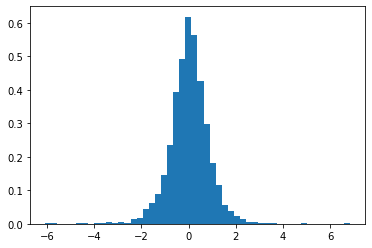

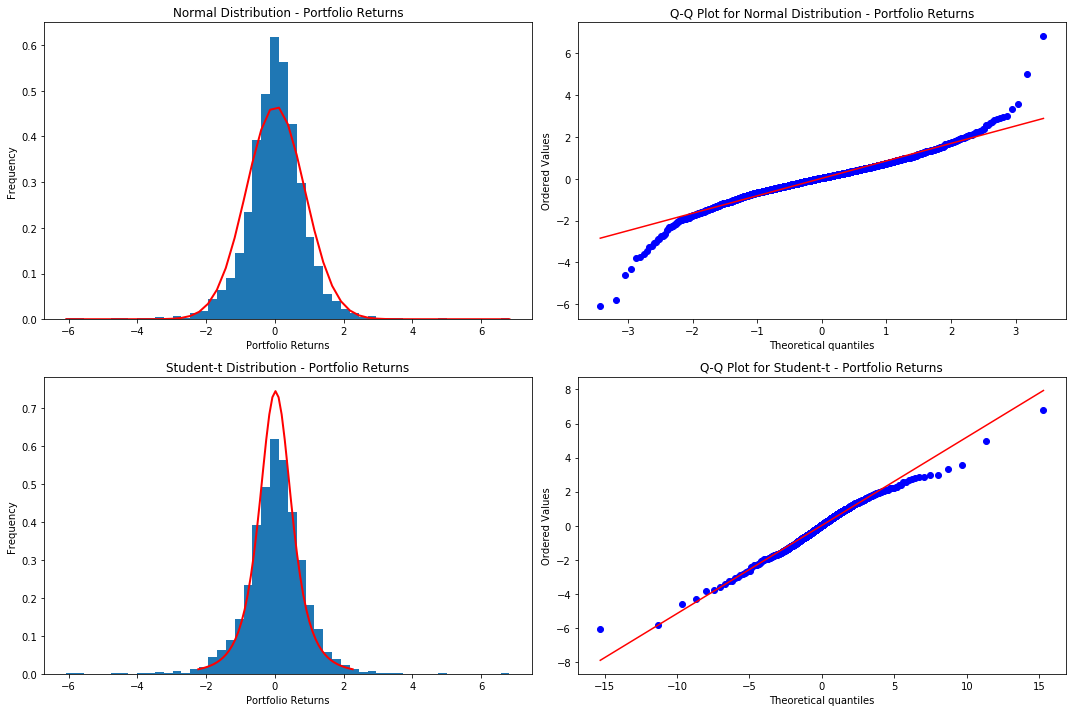

<IPython.core.display.Javascript object>

In [75]:
##assign df:
df = 3
# create distributions
mu = np.mean(data["portfolio_return"][1:])
sigma = np.std(data["portfolio_return"][1:])
sigmat = np.sqrt(np.var(data["portfolio_return"][1:]) * (df - 2) / df)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, normed=True)
normaldistr = (
    1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-((bins - mu) ** 2) / (2 * sigma ** 2))
)
tval = np.linspace(
    sc.stats.t.ppf(0.01, df, mu, sigmat), sc.stats.t.ppf(0.99, df, mu, sigmat), 51
)
tdistr = sc.stats.t.pdf(tval, df, mu, sigmat)  # Simulate t-distribution
### figure for t distr. and normal distr. comparison
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
# normal
plt.subplot(2, 2, 1)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, density=True)
plt.plot(bins, normaldistr, linewidth=2, color="r")
plt.xlabel("Portfolio Returns")
plt.ylabel("Frequency")
# plt.xlim( (-40000, 40000) )
plt.title("Normal Distribution - Portfolio Returns")
# normal qq
plt.subplot(2, 2, 2)
sc.stats.probplot(data["portfolio_return"][1:], dist="norm", plot=plt)
plt.title("Q-Q Plot for Normal Distribution - Portfolio Returns")
# stundent t
plt.subplot(2, 2, 3)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, density=True)
plt.plot(tval, tdistr, linewidth=2, color="r")
plt.xlabel("Portfolio Returns")
plt.ylabel("Frequency")
# plt.xlim( (-40000, 40000) )
plt.title("Student-t Distribution - Portfolio Returns")
# student t qq
plt.subplot(2, 2, 4)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(df), plot=plt)
plt.title("Q-Q Plot for Student-t - Portfolio Returns")
plt.tight_layout()
plt.show()

[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]


([<matplotlib.axis.XTick at 0x1e3afbdca88>,
 <a list of 5 Text xticklabel objects>)

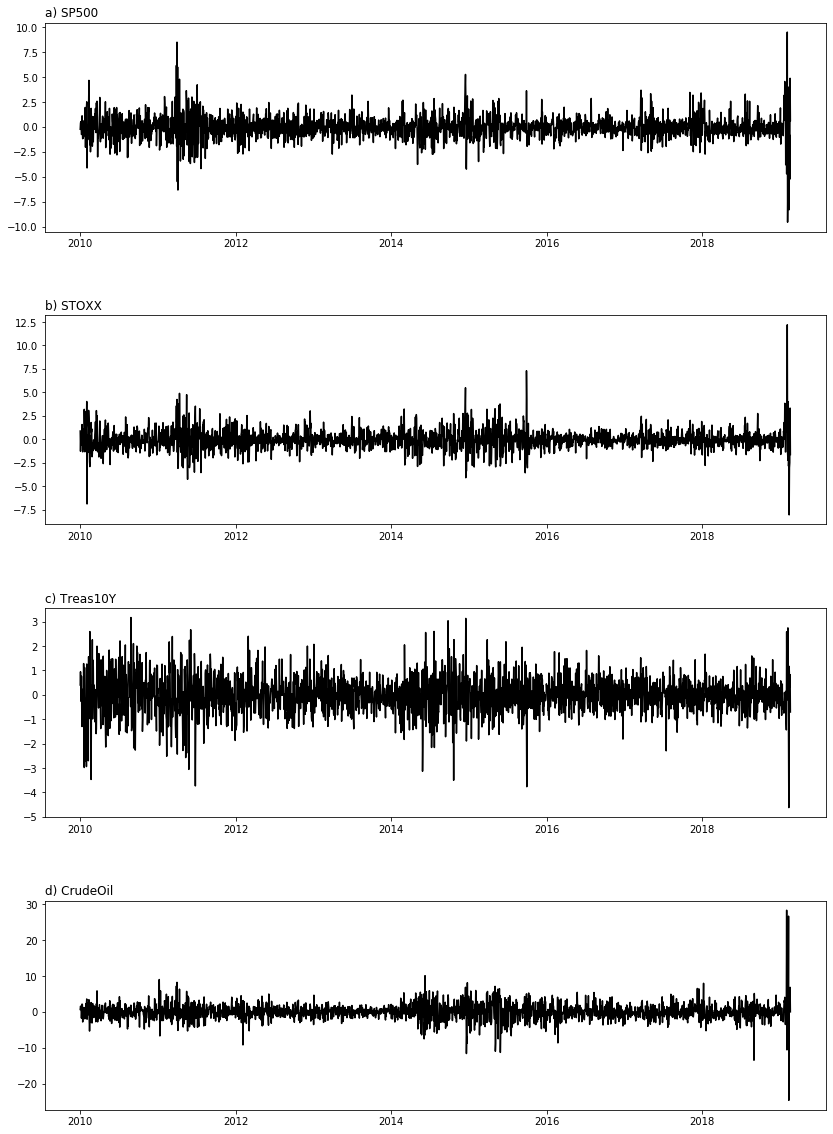

<IPython.core.display.Javascript object>

In [76]:
# plot of risk factor returns
"""I plot them as the negative of returns, so all are losses"""
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(14, 20))


# SP500
plt.subplot(4, 1, 1)
plt.plot(-data["SP500"][1:], "k")
plt.title("a) SP500", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
# STOXX
plt.subplot(4, 1, 2)
plt.plot(-data["STOXX"][1:], "k")
plt.title("b) STOXX", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
# Treas10Y
plt.subplot(4, 1, 3)
plt.plot(-data["Treas10Y"][1:], "k")
plt.title("c) Treas10Y", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
# CrudeOil
plt.subplot(4, 1, 4)
plt.plot(-data["CrudeOil"][1:], "k")
plt.title("d) CrudeOil", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.subplots_adjust(hspace=0.4)
plt.xticks(locs[1:-1], new_xticks)

In [78]:
""" All risk factors and portfolio return"""
df_prices = data[["SP500", "STOXX", "Treas10Y", "CrudeOil", "portfolio_return"]]

<IPython.core.display.Javascript object>

In [79]:
"""Statistics on risk factor and total return (log of index change)"""
df_prices.describe()

,SP500,STOXX,Treas10Y,CrudeOil,portfolio_return
count,2284.000000,2284.000000,2284.000000,2284.000000,2284.000000
mean,0.044282,0.021728,0.013870,-0.015222,0.019006
std,1.180474,1.072595,0.778457,2.340144,0.855937
min,-9.507371,-12.191490,-3.169709,-28.325419,-6.066456
25%,-0.526308,-0.459977,-0.441804,-1.131777,-0.426975
50%,0.078021,0.056295,0.003332,0.034901,0.038038
75%,0.663711,0.558345,0.476572,1.104670,0.492774
max,9.563211,8.070359,4.618856,24.637877,6.821613


<IPython.core.display.Javascript object>

In [80]:
df_prices.skew()

SP500              -0.214226
STOXX              -0.781290
Treas10Y            0.194341
CrudeOil           -0.760452
portfolio_return   -0.268679
dtype: float64

<IPython.core.display.Javascript object>

In [81]:
df_prices.kurtosis()

SP500                8.272307
STOXX               11.871997
Treas10Y             2.160380
CrudeOil            23.656145
portfolio_return     5.865710
dtype: float64

<IPython.core.display.Javascript object>

In [82]:
len(df_prices)

2284

<IPython.core.display.Javascript object>

## VaR and ES

### 1. Normal Distribution

In [83]:
def fnVaR_n(dfData, weights, alpha, lookback, percent, initial_investment):
    """
    purpose:
        calculates VaR and ES with variance-covariance method
        using a normal distribution
    input:
        dfData, dataframe
        weights, weights vector
        alpha, significance value
        lookback, lookback period
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha = 1 - alpha

    # express years in days
    years = lookback
    # select last n years of data
    DataTemp = dfData.iloc[-years :, :-1]  # converted to days

    # calculate mean
    mean = np.array(np.mean(DataTemp)) @ weights.T
    mean = mean[0]

    # calculate covariance
    cov = np.cov(DataTemp, rowvar=False)
    # calculate variance
    variance = weights @ cov @ weights.T
    std = np.sqrt(variance[0][0])

    # calculate quantile
    z = sc.stats.norm.ppf(alpha)
    VaR = (
        mean + z * std
    )  # μ is negative of the return over one day, so should be negative sign
    VaR = -VaR

    mean_return = dfData["portfolio_return"][-years  :]
    ES_list = [x for x in mean_return if x < -VaR]
    ES = -np.mean(ES_list)

    ##Prepare Output
    if percent[0] == True:
        print(
            "(",
            percent[1],
            "%",
            " VaR, ES) in percent is: ",
            round(VaR, 2),
            "%",
            round(ES, 2),
            "%",
        )
    else:

        print(
            "(",
            percent[1],
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),
        )

    return VaR, ES


<IPython.core.display.Javascript object>

#### 1.1. Non-stressed Estimates

In [84]:
# Set an initial investment level
initial_investment = 1000000
lookback = 2284
""" All time period"""

weights = np.array([[0.25, 0.25, 0.40, 0.2]])


fnVaR_n(df_prices, weights, 0.025, lookback, [True, 0.975], initial_investment)
fnVaR_n(df_prices, weights, 0.025, lookback, [False, 0.975], initial_investment)
fnVaR_n(df_prices, weights, 0.01, lookback, [True, 0.99], initial_investment)
fnVaR_n(df_prices, weights, 0.01, lookback, [False, 0.99], initial_investment)

( 0.975 %  VaR, ES) in percent is:  1.66 % 2.41 %
( 0.975 %  VaR, ES) in monetary terms is:  1658598.87 2409578.54
( 0.99 %  VaR, ES) in percent is:  1.97 % 2.95 %
( 0.99 %  VaR, ES) in monetary terms is:  1972200.28 2954318.39


(1.9722002832247685, 2.9543183900829018)

<IPython.core.display.Javascript object>

In [59]:
""" 8 year """
fnVaR_n(df_prices, weights, 0.025, 2000, [True, 0.975], initial_investment)
fnVaR_n(df_prices, weights, 0.025, 2000, [False, 0.975], initial_investment)
fnVaR_n(df_prices, weights, 0.01, 2000, [True, 0.99], initial_investment)
fnVaR_n(df_prices, weights, 0.01, 2000, [False, 0.99], initial_investment)

( 0.975 %  VaR, ES) in percent is:  1.65 % 2.42 %
( 0.975 %  VaR, ES) in monetary terms is:  1650696.78 2417756.64
( 0.99 %  VaR, ES) in percent is:  1.96 % 2.96 %
( 0.99 %  VaR, ES) in monetary terms is:  1963227.23 2962881.27


(1.9632272304777336, 2.9628812692415036)

<IPython.core.display.Javascript object>

In [60]:
""" 5 year """
fnVaR_n(df_prices, weights, 0.025, 1250, [True, 0.975], initial_investment)
fnVaR_n(df_prices, weights, 0.025, 1250, [False, 0.975], initial_investment)
fnVaR_n(df_prices, weights, 0.01, 1250, [True, 0.99], initial_investment)
fnVaR_n(df_prices, weights, 0.01, 1250, [False, 0.99], initial_investment)

( 0.975 %  VaR, ES) in percent is:  1.73 % 2.66 %
( 0.975 %  VaR, ES) in monetary terms is:  1734852.49 2657343.22
( 0.99 %  VaR, ES) in percent is:  2.06 % 3.15 %
( 0.99 %  VaR, ES) in monetary terms is:  2062698.19 3153044.17


(2.062698185363256, 3.1530441665507287)

<IPython.core.display.Javascript object>

In [61]:
""" 1 year """
fnVaR_n(df_prices, weights, 0.025, 250, [True, 0.975], initial_investment)
fnVaR_n(df_prices, weights, 0.025, 250, [False, 0.975], initial_investment)
fnVaR_n(df_prices, weights, 0.01, 250, [True, 0.99], initial_investment)
fnVaR_n(df_prices, weights, 0.01, 250, [False, 0.99], initial_investment)

( 0.975 %  VaR, ES) in percent is:  2.0 % 4.22 %
( 0.975 %  VaR, ES) in monetary terms is:  1997612.52 4221380.09
( 0.99 %  VaR, ES) in percent is:  2.38 % 4.22 %
( 0.99 %  VaR, ES) in monetary terms is:  2377383.6 4221380.09


(2.3773836018742296, 4.22138008984559)

<IPython.core.display.Javascript object>

## Sensitivity 

In [85]:
VaR_trend = []
ES_trend = []
VaR_trend_ex = []
ES_trend_ex = []
# Included corona period
for i in range(15, 2108):
    VaR_trend.append(
        fnVaR_n(df_prices, weights, 0.025, i, [True, 0.975], initial_investment)[0]
    )
    ES_trend.append(
        fnVaR_n(df_prices, weights, 0.025, i, [True, 0.975], initial_investment)[1]
    )

# exclude corona
for i in range(250):
    VaR_trend_ex.append(None)
    ES_trend_ex.append(None)
for i in range(15, 1859):
    VaR_trend_ex.append(
        fnVaR_n(df_prices[:-250], weights, 0.025, i, [True, 0.975], initial_investment)[
            0
        ]
    )
    ES_trend_ex.append(
        fnVaR_n(df_prices[:-250], weights, 0.025, i, [True, 0.975], initial_investment)[
            1
        ]
    )

C:\Users\Asus\.conda\envs\py37\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Asus\.conda\envs\py37\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


( 0.975 %  VaR, ES) in percent is:  7.59 % nan %
( 0.975 %  VaR, ES) in percent is:  7.59 % nan %
( 0.975 %  VaR, ES) in percent is:  7.3 % nan %
( 0.975 %  VaR, ES) in percent is:  7.3 % nan %
( 0.975 %  VaR, ES) in percent is:  7.06 % nan %
( 0.975 %  VaR, ES) in percent is:  7.06 % nan %
( 0.975 %  VaR, ES) in percent is:  6.9 % nan %
( 0.975 %  VaR, ES) in percent is:  6.9 % nan %
( 0.975 %  VaR, ES) in percent is:  6.93 % nan %
( 0.975 %  VaR, ES) in percent is:  6.93 % nan %
( 0.975 %  VaR, ES) in percent is:  6.77 % nan %
( 0.975 %  VaR, ES) in percent is:  6.77 % nan %
( 0.975 %  VaR, ES) in percent is:  6.68 % nan %
( 0.975 %  VaR, ES) in percent is:  6.68 % nan %
( 0.975 %  VaR, ES) in percent is:  6.52 % nan %
( 0.975 %  VaR, ES) in percent is:  6.52 % nan %
( 0.975 %  VaR, ES) in percent is:  6.36 % nan %
( 0.975 %  VaR, ES) in percent is:  6.36 % nan %
( 0.975 %  VaR, ES) in percent is:  6.21 % nan %
( 0.975 %  VaR, ES) in percent is:  6.21 % nan %
( 0.975 %  VaR, ES) in p

( 0.975 %  VaR, ES) in percent is:  2.75 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.75 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.74 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.74 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.72 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.72 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.72 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.72 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.71 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.71 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.7 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.7 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.68 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.68 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.67 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.67 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.66 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.66 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.65 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.65 % 4.22 %
( 

( 0.975 %  VaR, ES) in percent is:  2.11 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.11 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.1 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.1 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.1 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.1 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.09 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.09 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.09 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.09 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.08 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.08 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.08 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.08 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.07 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.07 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.06 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.06 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.06 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.06 % 4.22 %
( 0.

( 0.975 %  VaR, ES) in percent is:  1.9 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.9 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.9 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.9 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.9 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.9 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.9 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.9 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.89 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.89 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.89 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.89 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.89 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.89 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.89 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.89 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.89 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.89 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.88 % 3.68 %
( 0.975 %  VaR, ES) in percent is:  1.88 % 3.68 %
( 0.975 

( 0.975 %  VaR, ES) in percent is:  1.78 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.77 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.77 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.77 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.77 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.77 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.77 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.77 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.77 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.77 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.77 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.76 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.76 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.76 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.76 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.76 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.76 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.76 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.76 % 3.31 %
( 0.975 %  VaR, ES) in percent is:  1.76 % 3.31 %


( 0.975 %  VaR, ES) in percent is:  1.67 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 3.06 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 3.06 %


( 0.975 %  VaR, ES) in percent is:  1.61 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.78 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.78 %
( 0.975 %  Va

( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.71 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 2.71 %


( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.56 %


( 0.975 %  VaR, ES) in percent is:  1.6 % 2.58 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.58 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.58 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.58 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.55 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.55 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.51 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.51 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.51 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.51 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.51 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.51 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.51 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.51 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.51 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.51 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.51 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.51 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.51 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.51 %
( 0.

( 0.975 %  VaR, ES) in percent is:  1.71 % 2.73 %
( 0.975 %  VaR, ES) in percent is:  1.71 % 2.73 %
( 0.975 %  VaR, ES) in percent is:  1.71 % 2.73 %
( 0.975 %  VaR, ES) in percent is:  1.71 % 2.73 %
( 0.975 %  VaR, ES) in percent is:  1.71 % 2.69 %
( 0.975 %  VaR, ES) in percent is:  1.71 % 2.69 %
( 0.975 %  VaR, ES) in percent is:  1.71 % 2.69 %
( 0.975 %  VaR, ES) in percent is:  1.71 % 2.69 %
( 0.975 %  VaR, ES) in percent is:  1.71 % 2.69 %
( 0.975 %  VaR, ES) in percent is:  1.71 % 2.69 %
( 0.975 %  VaR, ES) in percent is:  1.71 % 2.69 %
( 0.975 %  VaR, ES) in percent is:  1.71 % 2.69 %
( 0.975 %  VaR, ES) in percent is:  1.71 % 2.69 %
( 0.975 %  VaR, ES) in percent is:  1.71 % 2.69 %
( 0.975 %  VaR, ES) in percent is:  1.71 % 2.69 %
( 0.975 %  VaR, ES) in percent is:  1.71 % 2.69 %
( 0.975 %  VaR, ES) in percent is:  1.7 % 2.69 %
( 0.975 %  VaR, ES) in percent is:  1.7 % 2.69 %
( 0.975 %  VaR, ES) in percent is:  1.7 % 2.69 %
( 0.975 %  VaR, ES) in percent is:  1.7 % 2.69 %
( 0.

( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.73 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.73 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.68 %


( 0.975 %  VaR, ES) in percent is:  1.72 % 2.63 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.63 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.63 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.63 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.63 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.63 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.63 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.63 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.63 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.6 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.6 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.6 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.6 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.6 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.6 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.6 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.6 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.6 %
( 0.975 %  VaR, ES) in percent is:  1.72 % 2.6 %
( 0.975 %  VaR, ES) in percent is:  1.71 % 2.6 %
( 0.975 %  

( 0.975 %  VaR, ES) in percent is:  1.68 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.68 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.68 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 2.5 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 2.5 %
( 0.975 %  VaR, ES) 

( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 2.41 %


( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.39 %


( 0.975 %  VaR, ES) in percent is:  1.61 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.36 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.36 %
( 0.975 %  V

( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %


( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.33 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.32 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.32 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.32 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.32 %
( 0.975 %  VaR, ES) in percent is:  1.58 % 2.3 %
( 0.975 %  VaR, ES) in percent is:  1.58 % 2.3 %
( 0.975 %  VaR, ES) in percent is:  1.58 % 2.29 %
( 0.975 %  VaR, ES) in percent is:  1.58 % 2.29 %
( 0.975 %  VaR, ES) in percent is:  1.58 % 2.29 %
( 0.975 %  VaR, ES) in percent is:  1.58 % 2.29 %
( 0.975 %  VaR, ES) in percent is:  1.58 % 2.29 %
( 0.975 %  VaR, ES) in percent is:  1.58 % 2.29 %
( 0.975 %  VaR, ES) in percent is:  1.58 % 2.29 %
( 0.975 %  VaR, ES) in percent is:  1.58 % 2.29 %
( 0.975 %  VaR, ES) in percent is:  1.58 % 2.29 %
( 0.975 %  VaR, ES) in percent is:  1.58 % 2.29 %
( 0.975 %  VaR, ES) in percent is:  1.58 % 2.29 %
( 

( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.28 %


( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 2.41 %


( 0.975 %  VaR, ES) in percent is:  1.64 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.67 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.65 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.63 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.63 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 1.97 %
( 0.97

( 0.975 %  VaR, ES) in percent is:  1.39 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.38 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.38 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.38 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.38 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 1.74 %


( 0.975 %  VaR, ES) in percent is:  1.31 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.71 %
( 0.975 % 

( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.66 %


( 0.975 %  VaR, ES) in percent is:  1.25 % 1.59 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.59 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.61 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.61 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.59 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.59 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.59 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.59 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.6 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.6 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.6 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.6 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.6 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.6 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.6 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.6 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.6 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.6 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.6 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.6 %
( 0.975 %  V

( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.63 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.63 %


( 0.975 %  VaR, ES) in percent is:  1.31 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.7 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.7 %
( 0.975 %  VaR, ES) 

( 0.975 %  VaR, ES) in percent is:  1.55 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.09 %
( 0.975 %  VaR, ES) in percent is:  1.59 % 2.09 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.14 %
( 0.975 % 

( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 2.14 %


( 0.975 %  VaR, ES) in percent is:  1.66 % 2.17 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.18 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.18 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.18 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.18 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.17 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.17 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.17 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.17 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.17 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.17 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.17 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.17 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.17 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.17 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.17 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.17 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.17 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.17 %
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.17 %


( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 2.12 %


( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.56 % 2.05 %


( 0.975 %  VaR, ES) in percent is:  1.54 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 2.05 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 2.05 %


( 0.975 %  VaR, ES) in percent is:  1.52 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.52 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.52 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.52 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.52 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.52 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.52 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.52 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.03 %
( 0.975 %  VaR, ES) in percent is:  1.53 % 2.03 %


( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) 

( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) in percent is:  1.51 % 2.0 %
( 0.975 %  VaR, ES) 

( 0.975 %  VaR, ES) in percent is:  1.54 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.55 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.54 % 1.99 %


( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.15 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 2.14 %
( 0.975 %  VaR, ES) 

<IPython.core.display.Javascript object>

The values without corona (stress period) are lower


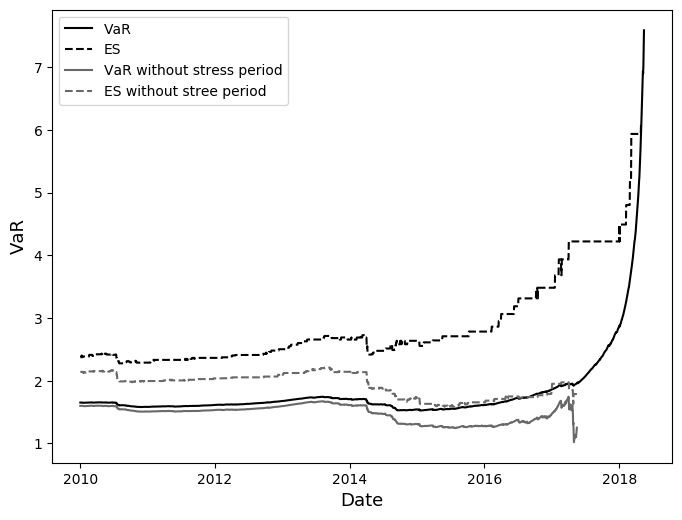

<IPython.core.display.Javascript object>

In [87]:
print("The values without corona (stress period) are lower")
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(VaR_trend[::-1], label="VaR", color="k")
plt.plot(ES_trend[::-1], label="ES", color="k", ls="--")
plt.plot(VaR_trend_ex[::-1], label="VaR without stress period", color="#696969")
plt.plot(ES_trend_ex[::-1], label="ES without stree period", color="#696969", ls="--")
# plt.xticks(np.arange(8), (1, 2, 3, 4, 5, 6, 7, 8))
plt.xlabel("Date", fontsize=13)
plt.ylabel("VaR", fontsize=13)
locs, labels = plt.xticks()
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
plt.legend()

In [88]:
VaR_trend = []
ES_trend = []
VaR_trend_ex = []
ES_trend_ex = []
# Included corona period
for i in range(15, 2108):
    VaR_trend.append(
        fnVaR_n(df_prices, weights, 0.01, i, [True, 0.99], initial_investment)[0]
    )
    ES_trend.append(
        fnVaR_n(df_prices, weights, 0.01, i, [True, 0.99], initial_investment)[1]
    )

# exclude corona
for i in range(250):
    VaR_trend_ex.append(None)
    ES_trend_ex.append(None)
for i in range(15, 1859):
    VaR_trend_ex.append(
        fnVaR_n(df_prices[:-250], weights, 0.01, i, [True, 0.99], initial_investment)[0]
    )
    ES_trend_ex.append(
        fnVaR_n(df_prices[:-250], weights, 0.01, i, [True, 0.99], initial_investment)[1]
    )

( 0.99 %  VaR, ES) in percent is:  8.88 % nan %
( 0.99 %  VaR, ES) in percent is:  8.88 % nan %
( 0.99 %  VaR, ES) in percent is:  8.56 % nan %
( 0.99 %  VaR, ES) in percent is:  8.56 % nan %
( 0.99 %  VaR, ES) in percent is:  8.28 % nan %
( 0.99 %  VaR, ES) in percent is:  8.28 % nan %
( 0.99 %  VaR, ES) in percent is:  8.09 % nan %
( 0.99 %  VaR, ES) in percent is:  8.09 % nan %
( 0.99 %  VaR, ES) in percent is:  8.1 % nan %
( 0.99 %  VaR, ES) in percent is:  8.1 % nan %
( 0.99 %  VaR, ES) in percent is:  7.91 % nan %
( 0.99 %  VaR, ES) in percent is:  7.91 % nan %
( 0.99 %  VaR, ES) in percent is:  7.79 % nan %
( 0.99 %  VaR, ES) in percent is:  7.79 % nan %
( 0.99 %  VaR, ES) in percent is:  7.6 % nan %
( 0.99 %  VaR, ES) in percent is:  7.6 % nan %
( 0.99 %  VaR, ES) in percent is:  7.42 % nan %
( 0.99 %  VaR, ES) in percent is:  7.42 % nan %
( 0.99 %  VaR, ES) in percent is:  7.25 % nan %
( 0.99 %  VaR, ES) in percent is:  7.25 % nan %
( 0.99 %  VaR, ES) in percent is:  7.09 % na

( 0.99 %  VaR, ES) in percent is:  2.99 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.98 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.98 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.97 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.97 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.96 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.96 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.95 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.95 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.95 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.95 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.94 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.94 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.93 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.93 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.93 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.93 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.92 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.92 % 4.49 %
( 0.99 %  VaR, ES) in percent is:  2.91 % 4.49 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  2.32 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.32 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.32 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.32 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.31 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.31 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.31 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.31 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.31 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.31 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.3 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.3 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.3 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.3 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.29 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.29 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.29 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.29 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.3 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.3 % 4.22 %
( 0.99 %  VaR, ES) in perc

( 0.99 %  VaR, ES) in percent is:  2.16 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.17 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.17 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.16 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.16 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.16 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.16 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.16 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.16 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.16 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.16 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.16 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.16 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.16 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.16 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.15 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.15 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.15 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.15 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.16 % 3.94 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  2.04 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.04 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.04 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.04 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.04 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.04 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.04 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.04 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.04 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.04 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.94 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.93 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.94 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.94 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.88 % 3.49 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.87 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.87 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.87 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.87 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.87 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.87 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.87 % 3.33 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.83 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.33 %
( 0.99 %  VaR, ES) in percent is:  1.84 % 3.21 %
( 0.99 %  VaR, ES) in percent is:  1.84 % 3.21 %
( 0.99 %  VaR, ES) in percent is:  1.84 % 3.21 %
( 0.99 %  VaR, ES) in percent is:  1.84 % 3.21 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.83 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 3.2 %
( 0.99 %  VaR, ES) in percent is:  1.82 

( 0.99 %  VaR, ES) in percent is:  1.92 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 2.97 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 2.97 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 3.04 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) in percent is:  2.03 % 3.26 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  2.04 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.04 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.04 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.18 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.18 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  2.05 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.05 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.04 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.04 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.04 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.04 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.04 % 3.15 %
( 0.99 %  VaR, ES) in percent is:  2.04 % 3.15 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.09 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.95 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.92 % 2.87 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.87 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.84 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.9 % 2.8 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.8 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.8 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.8 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.8 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.8 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.8 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.8 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.8 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.8 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 

( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.77 %
( 0.99 %  VaR, ES) in percent is: 

( 0.99 %  VaR, ES) in percent is:  1.96 % 2.96 %
( 0.99 %  VaR, ES) in percent is:  1.96 % 2.96 %
( 0.99 %  VaR, ES) in percent is:  1.96 % 2.96 %
( 0.99 %  VaR, ES) in percent is:  1.96 % 2.96 %
( 0.99 %  VaR, ES) in percent is:  1.96 % 2.96 %
( 0.99 %  VaR, ES) in percent is:  1.96 % 2.96 %
( 0.99 %  VaR, ES) in percent is:  1.96 % 3.0 %
( 0.99 %  VaR, ES) in percent is:  1.96 % 3.0 %
( 0.99 %  VaR, ES) in percent is:  1.96 % 2.96 %
( 0.99 %  VaR, ES) in percent is:  1.96 % 2.96 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.0 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.0 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.0 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.0 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.0 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.0 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.0 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.0 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.0 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 3.0 %
( 0.99 %  VaR, ES) in percent is

( 0.99 %  VaR, ES) in percent is:  1.96 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.92 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.89 % 2.07 %
( 0.99 %  VaR, ES) in perc

( 0.99 %  VaR, ES) in percent is:  1.65 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.65 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.65 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.65 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.65 % 1.89 %
( 0.99 %  VaR, ES) in percent is:  1.65 % 1.89 %
( 0.99 %  VaR, ES) in percent is:  1.64 % 1.89 %
( 0.99 %  VaR, ES) in percent is:  1.64 % 1.89 %
( 0.99 %  VaR, ES) in percent is:  1.65 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.65 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.65 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.65 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.64 % 1.89 %
( 0.99 %  VaR, ES) in percent is:  1.64 % 1.89 %
( 0.99 %  VaR, ES) in percent is:  1.64 % 1.89 %
( 0.99 %  VaR, ES) in percent is:  1.64 % 1.89 %
( 0.99 %  VaR, ES) in percent is:  1.63 % 1.89 %
( 0.99 %  VaR, ES) in percent is:  1.63 % 1.89 %
( 0.99 %  VaR, ES) in percent is:  1.63 % 1.89 %
( 0.99 %  VaR, ES) in percent is:  1.63 % 1.89 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.55 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.54 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.54 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.54 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.54 % 1.86 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.51 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.81 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.49 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 1.78 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 1.78 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 1.95 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.67 % 2.05 %
( 0.99 %  VaR, ES) in percent is:  1.68 % 2.05 %
( 0.99 %  VaR, ES) in percent is:  1.68 % 2.05 %
( 0.99 %  VaR, ES) in percent is:  1.7 % 2.12 %
( 0.99 %  VaR, ES) in percent is:  1.7 % 2.12 %
( 0.99 %  VaR, ES) in percent is:  1.71 % 2.1 %
( 0.99 %  VaR, ES) in percent is:  1.71 % 2.1 %
( 0.99 %  VaR, ES) in percent is:  1.7 % 2.1 %
( 0.99 %  VaR, ES) in percent is:  1.7 % 2.1 %
( 0.99 %  VaR, ES) in percent is:  1.7 % 2.1 %
( 0.99 %  VaR, ES) in percent is:  1.7 % 2.1 %
( 0.99 %  VaR, ES) in percent is:  1.7 % 2.1 %
( 0.99 %  VaR, ES) in percent is:  1.7 % 2.1 %
( 0.99 %  VaR, ES) in percent is:  1.71 % 2.1 %
( 0.99 %  VaR, ES) in percent is:  1.71 % 2.1 %
( 0.99 %  VaR, ES) in percent is:  1.72 % 2.08 %
( 0.99 %  VaR, ES) in percent is:  1.72 % 2.08 %
( 0.99 %  VaR, ES) in percent is:  1.72 % 2.08 %
( 0.99 %  VaR, ES) in percent is:  1.72 % 2.08 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 2.08 %
( 0.99 %  VaR, ES) in percent is:  1.7

( 0.99 %  VaR, ES) in percent is:  1.9 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.44 %
( 0.99 %  VaR, ES) in perc

( 0.99 %  VaR, ES) in percent is:  1.98 % 2.61 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.66 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.66 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.61 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.61 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.61 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.61 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.61 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.61 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.61 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.61 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.61 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.61 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.61 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.61 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.61 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.61 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.66 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.66 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 2.66 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.94 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 2.53 %
( 0.99 %  VaR, ES) in percent is:  1.93 % 2.53 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.88 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.88 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.87 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.87 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.87 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.87 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.87 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.87 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.87 % 2.4 %
( 0.99 %  VaR, ES) in percent is:  1.87 

( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.36 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.82 % 2.33 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.8 

( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.79 % 2.33 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.84 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.84 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.84 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.84 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.84 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.84 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.84 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.84 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.84 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.84 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.83 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.85 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.85 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.85 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.85 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.85 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.85 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.85 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.85 % 2.33 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.91 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.91 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  VaR, ES) in percent is:  1.9 % 2.5 %
( 0.99 %  

<IPython.core.display.Javascript object>

The values without corona (stress period) are lower


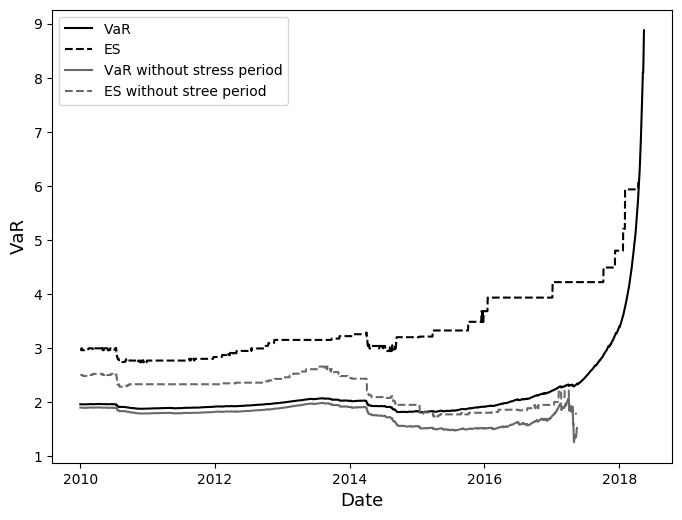

<IPython.core.display.Javascript object>

In [89]:
print("The values without corona (stress period) are lower")
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(VaR_trend[::-1], label="VaR", color="k")
plt.plot(ES_trend[::-1], label="ES", color="k", ls="--")
plt.plot(VaR_trend_ex[::-1], label="VaR without stress period", color="#696969")
plt.plot(ES_trend_ex[::-1], label="ES without stree period", color="#696969", ls="--")
# plt.xticks(np.arange(8), (1, 2, 3, 4, 5, 6, 7, 8))
plt.xlabel("Date", fontsize=13)
plt.ylabel("VaR", fontsize=13)
locs, labels = plt.xticks()
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
plt.legend()

### 2. Student t-distribution

### Check student t-assumption with QQ-plots

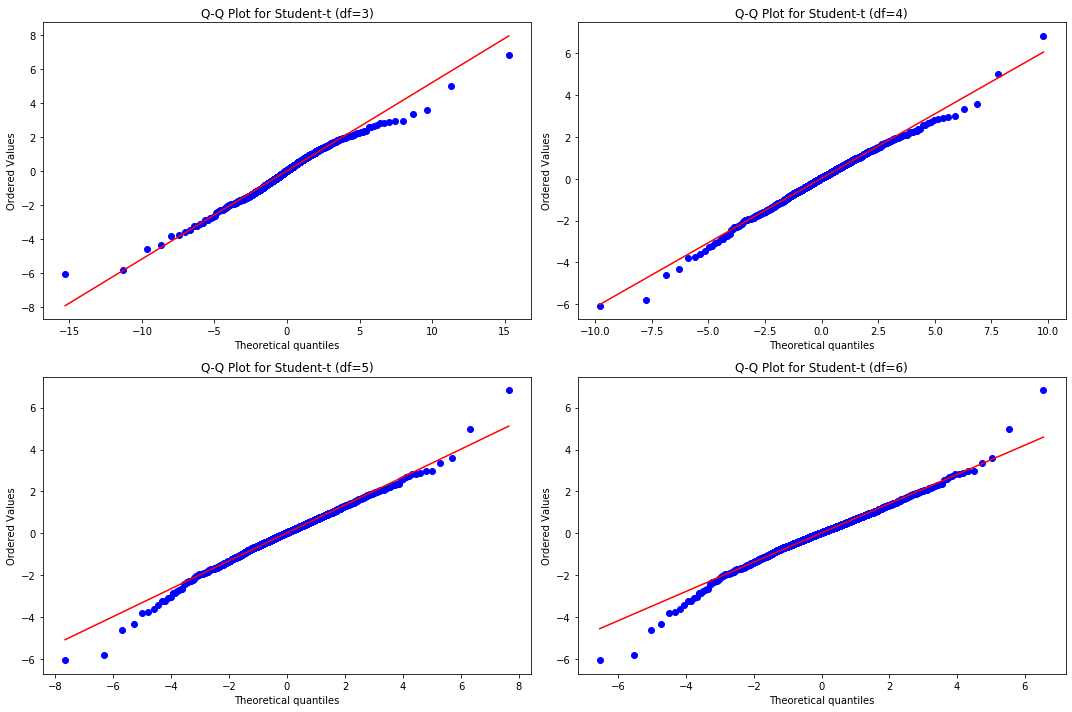

<IPython.core.display.Javascript object>

In [90]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
plt.subplot(2, 2, 1)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(3), plot=plt)
plt.title("Q-Q Plot for Student-t (df=3)")
plt.tight_layout()
plt.subplot(2, 2, 2)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(4), plot=plt)
plt.title("Q-Q Plot for Student-t (df=4)")
plt.tight_layout()
plt.subplot(2, 2, 3)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(5), plot=plt)
plt.title("Q-Q Plot for Student-t (df=5)")
plt.tight_layout()
plt.subplot(2, 2, 4)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(6), plot=plt)
plt.title("Q-Q Plot for Student-t (df=6)")
plt.tight_layout()
plt.show()

In [91]:
def fnVaR_t(dfData, weights, lookback, df, alpha, percent, initial_investment):
    """
    purpose:
        calculates VaR and ES with variance-covariance method
        using a t-distribution
    input:
        dfData, dataframe
        weights, weights vector
        apha, significance value
        lookback, lookback period
        df, degrees of freedom
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha = 1 - alpha

    # express years in days
    years = lookback
    # select last n years of data
    DataTemp = dfData.iloc[-years:, :-1]  # converted to days

    # calculate mean
    mean = np.array(np.mean(DataTemp)) @ weights.T
    mean = mean[0]

    # calculate covariance
    cov = np.cov(DataTemp, rowvar=False)
    # calculate variance
    variance = weights @ cov @ weights.T
    variance = (
        variance[0][0] * (df - 2) / df
    )  # account for variance of standard student-t

    # calculate quantile
    t = sc.stats.t.ppf(alpha, df)
    VaR = mean + t * np.sqrt(variance)
    VaR = -VaR

    # calculate ES
    mean_return = dfData["portfolio_return"][-years:]
    ES_list = [x for x in mean_return if x < -VaR]
    ES = -np.mean(ES_list)

    ##Prepare Output
    if percent[0] == True:
        print(
            "DF=", df,
        )

        print(
            "(",
            percent[1],
            "%",
            " VaR, ES) in percent is: ",
            round(VaR, 2),
            "%",
            round(ES, 2),
            "%",
        )
    else:
        print(
            "(",
            percent[1],
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),
        )
    return VaR, ES

<IPython.core.display.Javascript object>

#### 2.1. Non-stressed Estimates

In [92]:
fnVaR_t(df_prices, weights, lookback, 3, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 3, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 3, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, lookback, 3, 0.01, [False, 0.99], initial_investment)

fnVaR_t(df_prices, weights, lookback, 4, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 4, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 4, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, lookback, 4, 0.01, [False, 0.99], initial_investment)

fnVaR_t(df_prices, weights, lookback, 5, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 5, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 5, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, lookback, 5, 0.01, [False, 0.99], initial_investment)

fnVaR_t(df_prices, weights, lookback, 6, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 6, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 6, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, lookback, 6, 0.01, [False, 0.99], initial_investment)

DF= 3
( 0.975 %  VaR, ES) in percent is:  1.55 % 2.24 %
( 0.975 %  VaR, ES) in monetary terms is:  1553680.08 2239892.46
DF= 3
( 0.99 %  VaR, ES) in percent is:  2.22 % 3.23 %
( 0.99 %  VaR, ES) in monetary terms is:  2224896.88 3231918.63
DF= 4
( 0.975 %  VaR, ES) in percent is:  1.66 % 2.41 %
( 0.975 %  VaR, ES) in monetary terms is:  1661405.64 2409578.54
DF= 4
( 0.99 %  VaR, ES) in percent is:  2.25 % 3.23 %
( 0.99 %  VaR, ES) in monetary terms is:  2248791.12 3231918.63
DF= 5
( 0.975 %  VaR, ES) in percent is:  1.69 % 2.42 %
( 0.975 %  VaR, ES) in monetary terms is:  1685304.22 2421511.51
DF= 5
( 0.99 %  VaR, ES) in percent is:  2.21 % 3.19 %
( 0.99 %  VaR, ES) in monetary terms is:  2211961.58 3192953.39
DF= 6
( 0.975 %  VaR, ES) in percent is:  1.69 % 2.45 %
( 0.975 %  VaR, ES) in monetary terms is:  1691065.55 2445960.31
DF= 6
( 0.99 %  VaR, ES) in percent is:  2.18 % 3.19 %
( 0.99 %  VaR, ES) in monetary terms is:  2177308.5 3192953.39


(2.177308504389573, 3.192953388767867)

<IPython.core.display.Javascript object>

In [59]:
''' 8 year '''
fnVaR_t(df_prices, weights, 2000, 3, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, 2000, 3, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, 2000, 3, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, 2000, 3, 0.01, [False, 0.99], initial_investment)

DF= 3
( 97.5 %  VaR, ES) in percent is:  2.51 % 4.21 %
( 97.5 %  VaR, ES) in monetary terms is:  25128.42 42108.88
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.61 % 5.64 %
( 99.0 %  VaR, ES) in monetary terms is:  36062.86 56431.94


(0.036062856724719886, 0.05643193911546341)

In [60]:
''' 5 year '''
fnVaR_t(df_prices, weights, 1250, 3, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, 1250, 3, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, 1250, 3, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, 1250, 3, 0.01, [False, 0.99], initial_investment)

DF= 3
( 97.5 %  VaR, ES) in percent is:  2.24 % 3.93 %
( 97.5 %  VaR, ES) in monetary terms is:  22434.82 39290.54
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.21 % 5.21 %
( 99.0 %  VaR, ES) in monetary terms is:  32143.13 52111.15


(0.03214312748363372, 0.05211115349281485)

In [61]:
''' 1 year '''
fnVaR_t(df_prices, weights, 250, 3, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, 250, 3, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, 250, 3, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, 250, 3, 0.01, [False, 0.99], initial_investment)

DF= 3
( 97.5 %  VaR, ES) in percent is:  3.05 % 6.33 %
( 97.5 %  VaR, ES) in monetary terms is:  30467.41 63269.68
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.34 % 8.4 %
( 99.0 %  VaR, ES) in monetary terms is:  43428.19 84016.37


(0.04342818509185923, 0.08401636813980118)

#### 2.2 Stressed Estimates

In [85]:
for name, df in zip(df_name, df_list):
    print(name)
    #fnVaR_t(df, weights, lookback, 3, 0.025, [True, 0.975], initial_investment)
    #fnVaR_t(df, weights, lookback, 3, 0.025, [False, 0.975], initial_investment)
    fnVaR_t(df, weights, lookback, 3, 0.01, [True, 0.99], initial_investment)
    fnVaR_t(df, weights, lookback, 3, 0.01, [False, 0.99], initial_investment)

df_prices_plus20
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.02 % 6.01 %
( 99.0 %  VaR, ES) in monetary terms is:  40243.83 60084.47
df_prices_plus40
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.14 % 6.36 %
( 99.0 %  VaR, ES) in monetary terms is:  41396.61 63558.14
df_prices_minus20
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.04 % 6.33 %
( 99.0 %  VaR, ES) in monetary terms is:  40425.07 63327.75
df_prices_minus40
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.33 % 7.5 %
( 99.0 %  VaR, ES) in monetary terms is:  43317.07 74998.7
df_prices_complus20
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.98 % 5.95 %
( 99.0 %  VaR, ES) in monetary terms is:  39799.63 59495.14
df_prices_complus40
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.99 % 5.95 %
( 99.0 %  VaR, ES) in monetary terms is:  39935.92 59495.14
df_prices_comminus20
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.98 % 5.95 %
( 99.0 %  VaR, ES) in monetary terms is:  39806.84 59495.14
df_prices_comminus40
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.01

In [86]:
for name, df in zip(df_name, df_list):
    print(name)
    #fnVaR_t(df, weights, lookback, 3, 0.025, [True, 0.975], initial_investment)
    #fnVaR_t(df, weights, lookback, 3, 0.025, [False, 0.975], initial_investment)
    fnVaR_t(df, weights, 500, 3, 0.01, [True, 0.99], initial_investment)
    fnVaR_t(df, weights, 500, 3, 0.01, [False, 0.99], initial_investment)

df_prices_plus20
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.87 % 6.97 %
( 99.0 %  VaR, ES) in monetary terms is:  38672.39 69731.22
df_prices_plus40
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.36 % 8.4 %
( 99.0 %  VaR, ES) in monetary terms is:  43600.77 84016.37
df_prices_minus20
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.94 % 7.76 %
( 99.0 %  VaR, ES) in monetary terms is:  39374.66 77552.68
df_prices_minus40
DF= 3
( 99.0 %  VaR, ES) in percent is:  5.1 % 14.59 %
( 99.0 %  VaR, ES) in monetary terms is:  50964.57 145949.37
df_prices_complus20
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.66 % 6.97 %
( 99.0 %  VaR, ES) in monetary terms is:  36605.54 69731.22
df_prices_complus40
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.73 % 6.97 %
( 99.0 %  VaR, ES) in monetary terms is:  37255.41 69731.22
df_prices_comminus20
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.66 % 6.97 %
( 99.0 %  VaR, ES) in monetary terms is:  36593.46 69731.22
df_prices_comminus40
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.

### 3. Historical simulation method

In [63]:
def fnVaR_hist(dfData, weights, alpha, lookback, percent, initial_investment):
    """
    purpose:
        calculates VaR and ES with historical simulation
    input:
        dfData, dataframe
        weights, weights vector
        apha, significance value
        lookback, lookback period
        df, degrees of freedom
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha = 1 - alpha

    # because the percentile function takes alpha=e[0,100]
    alpha = alpha * 100

    
    # express years in days
    years= lookback
    
    # select last n years of data
    DataTemp= dfData.iloc[-years:,-1]
    
    # calculate quantile
    VaR= sc.percentile(DataTemp, alpha)
    VaR= -VaR


    
    ES_list = [x for x in DataTemp if x < -VaR]
    ES = -np.mean(ES_list)

    ##Prepare Output
    if percent[0] == True:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in percent is: ",
            round(VaR * 100, 2),
            "%",
            round(ES * 100, 2),
            "%",
        )
    else:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),
        )
    return VaR, ES


#### 3.1. Non-stressed Estimates

In [64]:
fnVaR_hist(df_prices, weights, 0.025, lookback, [True, 0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.025, lookback, [False, 0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, lookback, [True, 0.99], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, lookback, [False, 0.99], initial_investment)

( 97.5 %  VaR, ES) in percent is:  3.12 % 5.08 %
( 97.5 %  VaR, ES) in monetary terms is:  31246.78 50783.69
( 99.0 %  VaR, ES) in percent is:  4.69 % 6.9 %
( 99.0 %  VaR, ES) in monetary terms is:  46858.29 68965.43


(0.0468582876622466, 0.06896542896415485)

In [65]:
''' 8 year '''
fnVaR_hist(df_prices, weights, 0.025, 2000, [True, 0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.025, 2000, [False, 0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, 2000, [True, 0.99], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, 2000, [False, 0.99], initial_investment)

( 97.5 %  VaR, ES) in percent is:  2.88 % 4.61 %
( 97.5 %  VaR, ES) in monetary terms is:  28816.52 46104.14
( 99.0 %  VaR, ES) in percent is:  4.1 % 6.4 %
( 99.0 %  VaR, ES) in monetary terms is:  41042.53 63989.97


(0.04104253315746949, 0.06398996887509285)

In [66]:
''' 5 year '''
fnVaR_hist(df_prices, weights, 0.025, 1250, [True, 0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.025, 1250, [False, 0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, 1250, [True, 0.99], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, 1250, [False, 0.99], initial_investment)

( 97.5 %  VaR, ES) in percent is:  2.47 % 4.17 %
( 97.5 %  VaR, ES) in monetary terms is:  24745.21 41737.75
( 99.0 %  VaR, ES) in percent is:  3.83 % 5.9 %
( 99.0 %  VaR, ES) in monetary terms is:  38278.2 58990.12


(0.03827820180250671, 0.05899011845310051)

In [67]:
''' 1 year '''
fnVaR_hist(df_prices, weights, 0.025, 250, [True, 0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.025, 250, [False, 0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, 250, [True, 0.99], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, 250, [False, 0.99], initial_investment)

( 97.5 %  VaR, ES) in percent is:  3.06 % 6.33 %
( 97.5 %  VaR, ES) in monetary terms is:  30585.4 63269.68
( 99.0 %  VaR, ES) in percent is:  5.95 % 9.56 %
( 99.0 %  VaR, ES) in monetary terms is:  59475.53 95568.93


(0.059475534861270704, 0.09556892955861118)

#### 3.2. Stressed Estimates

In [68]:
for name, df in zip(df_name, df_list):
    print(name)
    fnVaR_hist(df, weights, 0.025, lookback, [True, 0.975], initial_investment)
    fnVaR_hist(df, weights, 0.025, lookback, [False, 0.975], initial_investment)
    fnVaR_hist(df, weights, 0.01, lookback, [True, 0.99], initial_investment)
    fnVaR_hist(df, weights, 0.01, lookback, [False, 0.99], initial_investment)

df_prices_plus20
( 97.5 %  VaR, ES) in percent is:  3.12 % 5.08 %
( 97.5 %  VaR, ES) in monetary terms is:  31246.78 50783.69
( 99.0 %  VaR, ES) in percent is:  4.69 % 6.9 %
( 99.0 %  VaR, ES) in monetary terms is:  46858.29 68965.43
df_prices_plus40
( 97.5 %  VaR, ES) in percent is:  3.12 % 5.08 %
( 97.5 %  VaR, ES) in monetary terms is:  31246.78 50783.69
( 99.0 %  VaR, ES) in percent is:  4.69 % 6.9 %
( 99.0 %  VaR, ES) in monetary terms is:  46858.29 68965.43
df_prices_minus20
( 97.5 %  VaR, ES) in percent is:  3.18 % 5.25 %
( 97.5 %  VaR, ES) in monetary terms is:  31849.86 52540.42
( 99.0 %  VaR, ES) in percent is:  4.82 % 7.25 %
( 99.0 %  VaR, ES) in monetary terms is:  48193.43 72492.27
df_prices_minus40
( 97.5 %  VaR, ES) in percent is:  3.18 % 5.58 %
( 97.5 %  VaR, ES) in monetary terms is:  31849.86 55797.2
( 99.0 %  VaR, ES) in percent is:  4.82 % 8.03 %
( 99.0 %  VaR, ES) in monetary terms is:  48193.43 80338.15
df_prices_complus20
( 97.5 %  VaR, ES) in percent is:  3.12 %

### 4.Filtered historical simulation using EWMA

In [69]:
""" Filtered historical simulation using EWMA """
# returns = data[['DE_1YBOND_return',"BTC_return", "DBC_return", "GSPC_return", "N225_return"]]
def fnVaR_FilterEWMA(
    dfData, weights, ewma_con, alpha, lookback, percent, initial_investment
):
    returns = dfData
    # print(returns.shape)
    tVar = np.zeros((lookback // 250 * 250 + 100 + 1, 7))
    alpha = alpha * 100
    ##calculate variance at day-100 using the previous days
    for i in range(7):
        tVar[0, i] = returns.iloc[-(lookback // 250 * 250 + 101), i]

    # calculate first 100 days volatility
    for i in range(7):
        for j in range(100):
            tVar[1 + j, i] = (
                ewma_con * tVar[1 + j - 1, i]
                + (1 - ewma_con)
                * returns.iloc[-(lookback // 250 * 250 + 100) + j - 1, i] ** 2
            )
    # print(tVar)
    Z_matrix = np.zeros((500, 7))
    R_matrix = np.zeros((500, 7))
    VaR_all = np.zeros(7)
    ES_all = np.zeros(7)
    # calculate first 500 days Z values and use them to approximate the VaR and ES on the 501th day
    for i in range(7):
        for j in range(500):
            tVar[101 + j, i] = (
                ewma_con * tVar[101 + j - 1, i]
                + (1 - ewma_con)
                * returns.iloc[-(lookback // 250 * 250) + j - 1, i] ** 2
            )
            Z_matrix[j, i] = returns.iloc[
                -(lookback // 250 * 250 + 100) + j, i
            ] / sc.sqrt(tVar[101 + j, i])
            new_sigma = sc.sqrt(
                ewma_con * tVar[101 + j, i]
                + (1 - ewma_con) * returns.iloc[-(lookback // 250 * 250) + j, i] ** 2
            )
            R_matrix[:, i] = Z_matrix[:, i] * new_sigma
    #R_matrix[:, 0] = R_matrix[:, 0] + R_matrix[:, -2]
    #R_matrix[:, 4] = R_matrix[:, 4] + R_matrix[:, -1]
    for i in range(7):
        # print(new_sigma)
        VaR_all[i] = -sc.percentile(R_matrix[:, i], alpha)
        ES_list = [x for x in R_matrix[:, i] if x < -VaR_all[i]]
        ES_all[i] = -np.mean(ES_list)
        # print(VaR_all)
    VaR = (VaR_all @ weights.T)[0]
    ES = (ES_all @ weights.T)[0]

    if percent[0] == True:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in percent is: ",
            round(VaR * 100, 2),
            "%",
            round(ES * 100, 2),
            "%",
        )
    else:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),
        )
    return VaR, ES

#### 4.1. Non-stressed Estimates

In [70]:
"""For EWMA, because we calculate all seven variance and then add all five assests together,
 that why I set another new weights. Because Nikkei and Bond are one asset so they both should
only have one total VaR considering FX together. I already add two returns together in the function.
Let me know if you agree with it. :)"""


#weights2 = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.025, lookback, [True, 0.975], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.025, lookback, [False, 0.975], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.01, lookback, [True, 0.99], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.01, lookback, [False, 0.99], initial_investment
)

( 97.5 %  VaR, ES) in percent is:  7.47 % 10.99 %
( 97.5 %  VaR, ES) in monetary terms is:  74693.46 109887.12
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0 %  VaR, ES) in monetary terms is:  110585.34 145294.19


(0.11058534283796619, 0.14529418821140577)

In [71]:
''' 8 year VaR,ES'''
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.025, 2000, [True, 0.975], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.025, 2000, [False, 0.975], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.01, 2000, [True, 0.99], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.01, 2000, [False, 0.99], initial_investment
)

( 97.5 %  VaR, ES) in percent is:  7.47 % 10.99 %
( 97.5 %  VaR, ES) in monetary terms is:  74693.46 109887.12
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0 %  VaR, ES) in monetary terms is:  110585.34 145294.19


(0.11058534283796619, 0.14529418821140577)

In [72]:
''' 5 year VaR,ES'''
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.025, 1250, [True, 0.975], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.025, 1250, [False, 0.975], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.01, 1250, [True, 0.99], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.01, 1250, [False, 0.99], initial_investment
)

( 97.5 %  VaR, ES) in percent is:  6.78 % 11.2 %
( 97.5 %  VaR, ES) in monetary terms is:  67825.98 112011.41
( 99.0 %  VaR, ES) in percent is:  10.21 % 15.72 %
( 99.0 %  VaR, ES) in monetary terms is:  102133.16 157220.51


(0.10213316110675465, 0.1572205090501107)

In [73]:
df_prices

,DE_1YBOND_return,BTC_return,DBC_return,GSPC_return,N225_return,FX_EUR_return,FX_YEN_return,portfolio_return
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.097,-0.013473,0.006859,0.004951,-0.004800,0.002644,-0.002498,0.018137
2,-0.014,-0.129608,0.009073,0.000345,0.001081,0.004555,-0.010222,-0.027755
3,0.007,0.043172,0.000967,-0.000180,-0.010690,-0.000227,0.001010,0.008211
4,-0.005,0.041385,0.002896,0.002181,-0.003248,-0.000071,-0.012104,0.005208
...,...,...,...,...,...,...,...,...
2104,0.084,0.048445,0.021449,0.089683,0.068899,0.006545,-0.003319,0.063140
2105,-0.030,-0.008012,0.016660,0.011469,0.077314,0.003527,-0.002663,0.013659
2106,0.023,0.005281,-0.003484,0.060544,-0.046174,0.008015,0.002220,0.009880
2107,-0.091,-0.037413,-0.003497,-0.034268,0.038099,0.014467,0.016058,-0.019510


#### 4.2. Stressed Estimates

In [75]:
for name, df in zip(df_name, df_list):
    print(name)
    #fnVaR_FilterEWMA(df, weights, 0.94, 0.025, lookback, [True, 0.975], initial_investment)
    #fnVaR_FilterEWMA(df, weights, 0.94, 0.025, lookback, [False, 0.975], initial_investment)
    fnVaR_FilterEWMA(df, weights, 0.94, 0.01, lookback, [True, 0.99], initial_investment)
    fnVaR_FilterEWMA(df, weights, 0.94, 0.01, lookback, [False, 0.99], initial_investment)

df_prices_plus20
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0 %  VaR, ES) in monetary terms is:  110585.34 145294.19
df_prices_plus40
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0 %  VaR, ES) in monetary terms is:  110585.34 145294.19
df_prices_minus20
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0 %  VaR, ES) in monetary terms is:  110585.34 145294.19
df_prices_minus40
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0 %  VaR, ES) in monetary terms is:  110585.34 145294.19
df_prices_complus20
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0 %  VaR, ES) in monetary terms is:  110585.34 145294.19
df_prices_complus40
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0 %  VaR, ES) in monetary terms is:  110585.34 145294.19
df_prices_comminus20
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0 %  VaR, ES) in monetary terms is:  110585.34 145294.19
df_prices_comminus40
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0

In [76]:
for name, df in zip(df_name, df_list):
    print(name)
    #fnVaR_FilterEWMA(df, weights, 0.94, 0.025, lookback, [True, 0.975], initial_investment)
    #fnVaR_FilterEWMA(df, weights, 0.94, 0.025, lookback, [False, 0.975], initial_investment)
    fnVaR_FilterEWMA(df, weights, 0.94, 0.01, 500, [True, 0.99], initial_investment)
    fnVaR_FilterEWMA(df, weights, 0.94, 0.01, 500, [False, 0.99], initial_investment)

df_prices_plus20
( 99.0 %  VaR, ES) in percent is:  26.55 % 32.64 %
( 99.0 %  VaR, ES) in monetary terms is:  265475.94 326419.58
df_prices_plus40
( 99.0 %  VaR, ES) in percent is:  33.51 % 41.22 %
( 99.0 %  VaR, ES) in monetary terms is:  335068.72 412240.72
df_prices_minus20
( 99.0 %  VaR, ES) in percent is:  27.62 % 33.99 %
( 99.0 %  VaR, ES) in monetary terms is:  276217.48 339893.62
df_prices_minus40
( 99.0 %  VaR, ES) in percent is:  42.05 % 51.74 %
( 99.0 %  VaR, ES) in monetary terms is:  420509.58 517410.65
df_prices_complus20
( 99.0 %  VaR, ES) in percent is:  24.34 % 29.9 %
( 99.0 %  VaR, ES) in monetary terms is:  243394.66 298971.75
df_prices_complus40
( 99.0 %  VaR, ES) in percent is:  26.96 % 33.13 %
( 99.0 %  VaR, ES) in monetary terms is:  269642.92 331267.68
df_prices_comminus20
( 99.0 %  VaR, ES) in percent is:  25.1 % 30.83 %
( 99.0 %  VaR, ES) in monetary terms is:  250986.23 308312.44
df_prices_comminus40
( 99.0 %  VaR, ES) in percent is:  30.17 % 37.07 %
( 99.0 %

### 5. GARCH(1,1) with constant correlation matrix

In [52]:
from scipy.optimize import minimize


def fGarchFilter(vData, dOmega, dAlpha, dBeta, dSigma2):

    # initialize sizes and formats
    iT = vData.shape[0]
    vVariances = np.zeros(iT)
    vLikelihoodValues = np.ones(iT)

    # filter variances and compute likelihood contributions by
    # a loop over the observations
    for i1 in range(iT):

        # update filtered variances
        vVariances[i1] = dSigma2

        # compute the likelihood contribution
        vLikelihoodValues[i1] = (
            -0.5 * np.log(dSigma2) - 0.5 * vData.iloc[i1] * vData.iloc[i1] / dSigma2
        )

        # update the filter
        dSigma2 = dOmega + dBeta * dSigma2 + dAlpha * vData.iloc[i1] * vData.iloc[i1]

    # add likelihood constants
    vLikelihoodValues = vLikelihoodValues - 0.5 * np.log(2 * np.pi)

    # return filtered variances and likelihood values
    return (vVariances, vLikelihoodValues)


class cMaximizeLikelihood:
    def __init__(self):
        self.x0 = []
        self.x = []
        self.tx0 = []
        self.tx = []
        self.likelihoodvalue = []
        self.tcovariancematrix = []
        self.covariancematrix = []
        self.filter = []
        self.success = False


def fMaximizeLikelihood(vData):

    cReturnValue = cMaximizeLikelihood()

    def LOCAL_fParameterTransform(vTheta, bShapeAsVector=False):
        r = ((np.exp(vTheta[0])), (np.exp(vTheta[1])), (1 / (1 + np.exp(-vTheta[2]))))
        if bShapeAsVector == True:
            return np.append([], r)
        else:
            return r

    def LOCAL_fObjective(vTheta, bForAllT=False):
        # initialize the parameter values
        dOmega, dAlpha, dBeta = LOCAL_fParameterTransform(vTheta)
        dSigma2 = np.var(vData)

        # run the filter
        vVariances, vLikelihoodValues = fGarchFilter(
            vData, dOmega, dAlpha, dBeta, dSigma2
        )
        cReturnValue.filter = vVariances
        if bForAllT == True:
            dObjValue = vLikelihoodValues
        else:
            dObjValue = -np.mean(vLikelihoodValues)

        return dObjValue

    # initialize starting values and return value
    vTheta = np.log([1, 0.05, 0.93])
    vTheta[0] = np.log(np.var(vData) * (1 - 0.98))
    cReturnValue.x0 = vTheta
    cReturnValue.tx0 = LOCAL_fParameterTransform(vTheta)

    # do the optimization
    tSol = minimize(
        LOCAL_fObjective,
        vTheta,
        method="BFGS",#Nelder-Mead
        options={"disp": True, "maxiter": 100,"gtol": 1e-7 * len(vData)},
    )
    cReturnValue.success = tSol["success"]
    # check for success and store results
    if tSol["success"] != True:
        print("*** no true convergence: ", tSol["message"])
    else:
        cReturnValue.x = tSol["x"]
        cReturnValue.tx = LOCAL_fParameterTransform(cReturnValue.x)
        cReturnValue.likelihoodvalue = -vData.shape[0] * tSol["fun"]

    return cReturnValue

In [53]:
def fnVaR_GARCH(dfData, weights, alpha, lookback, percent,initial_investment,para=None,Variances = None,rec=True):
    """
    purpose:
        calculates VaR and ES with GARCH method
        using a normal distribution
    input:
        dfData, dataframe
        weights, weights vector
        apha, significance value
        lookback, lookback period
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha= 1-alpha
    
    # express years in days
    years= lookback
    # select last n years of data
    DataTemp= dfData.iloc[-years:,:-1]
    # calculate covariance using the 500 days before the beginning day
    corr =  DataTemp.iloc[-years:,:].corr()
    #cov= np.cov(DataTemp.iloc[1:,:], rowvar= False)    
    # estimate a GARCH(1,1) model and store the one step ahead
    # forecasts in a vector
    vVariances= np.zeros(7)
    # don't recalculate
    if rec == False:
        for i in range(7):
            dOmega, dAlpha, dBeta= para[i][0],para[i][1],para[i][2]
            sigma2hat= dOmega + dAlpha*DataTemp.iloc[-1,i]**2+dBeta*Variances[i]
            vVariances[i]= sigma2hat
        
   
    #recalculate
    else:
        para = []
        for i in range(7):
            out = fMaximizeLikelihood(DataTemp.iloc[:,i])
            dOmega, dAlpha, dBeta= out.tx
            sigma2hat= dOmega + dAlpha*DataTemp.iloc[-1,i]**2+dBeta*out.filter[-1]
            vVariances[i]= sigma2hat
            para.append([dOmega, dAlpha, dBeta])
    #print(vVariances)     
    # fill diagonal elements of covariance matrix with GARCH estimates
    sigmamatrix = np.zeros((7, 7))
    np.fill_diagonal(sigmamatrix, np.sqrt(vVariances))
    cov = np.matmul(np.matmul(sigmamatrix,corr),sigmamatrix)
    #np.fill_diagonal(cov, vVariances)
    # calculate the variance
    variance= weights@cov@weights.T
    variance= variance[0][0]
    # calculate mean
    mean= np.array(np.mean(DataTemp))@weights.T
    mean= mean[0]
    # calculate quantile
    z= sc.stats.norm.ppf(alpha)
    VaR= mean + z * np.sqrt(variance)
    VaR= -VaR
    # calculate ES
    mean_return = dfData["portfolio_return"][-years :]
    ES_list = [x for x in mean_return if x < -VaR]
    ES= -np.mean(ES_list)
    if percent[0] == True:
        print(
            "(",
            percent[1]* 100,
            "%",
            " VaR, ES) in percent is: ",
            round(VaR * 100, 2),
            "%",
            round(ES * 100, 2),
            "%", 
        )
    else:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),)
    return VaR, ES, para,vVariances

#### 5.1 Non-stress tesing

In [104]:
''' All period Var, ES'''
fnVaR_GARCH(df_prices,weights, 0.025, lookback, [True,0.975],initial_investment,para=None,Variances = None,rec=True)
fnVaR_GARCH(df_prices,weights, 0.025, lookback, [False,0.975],initial_investment,para=None,Variances = None,rec=True)
fnVaR_GARCH(df_prices,weights, 0.01, lookback, [True,0.99],initial_investment,para=None,Variances = None,rec=True)
fnVaR_GARCH(df_prices,weights, 0.01, lookback, [False,0.99],initial_investment,para=None,Variances = None,rec=True)

Optimization terminated successfully.
         Current function value: -2.512991
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -1.537345
         Iterations: 19
         Function evaluations: 100
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -3.213974
         Iterations: 26
         Function evaluations: 135
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: -3.365280
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -2.991514
         Iterations: 22
         Function evaluations: 115
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -3.815467
         Iterations: 24
         Function evaluat

(0.06274931207273222,
 0.08211182798520086,
 [[1.5390636451012193e-05, 0.10306732668269492, 0.8706724668625103],
  [0.0001067340025717166, 0.19291215488640212, 0.8110505623975162],
  [1.0331949447687074e-06, 0.0522090371388761, 0.9401376685012316],
  [4.988419575063573e-06, 0.20886479092257296, 0.7511119818146985],
  [4.516664598529438e-06, 0.1049300494623273, 0.8740851833549501],
  [1.510487267908553e-07, 0.03795852606110087, 0.9582399299729539],
  [7.39296061799043e-07, 0.07002624550745913, 0.9135425997452621]],
 array([1.96509452e-03, 7.68359381e-03, 5.27275509e-04, 2.34216473e-03,
        1.38127649e-03, 5.75986496e-05, 1.15206249e-04]))

In [121]:
''' 8 year Var, ES'''
fnVaR_GARCH(df_prices,weights, 0.025, 2000, [True,0.975],initial_investment,para=None,Variances = None,rec=True)
fnVaR_GARCH(df_prices,weights, 0.025, 2000, [False,0.975],initial_investment,para=None,Variances = None,rec=True)
fnVaR_GARCH(df_prices,weights, 0.01, 2000, [True,0.99],initial_investment,para=None,Variances = None,rec=True)
fnVaR_GARCH(df_prices,weights, 0.01, 2000, [False,0.99],initial_investment,para=None,Variances = None,rec=True)

Optimization terminated successfully.
         Current function value: -2.558515
         Iterations: 21
         Function evaluations: 110
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: -1.584932
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -3.252467
         Iterations: 23
         Function evaluations: 120
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: -3.390189
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -2.991034
         Iterations: 21
         Function evaluations: 110
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: -3.839636
         Iterations: 24
         Function evaluat

(0.06069092051083729,
 0.08309402158821273,
 [[1.8291445582764277e-05, 0.10424493885735371, 0.8587366675130739],
  [0.0001061740337965825, 0.1817598557207454, 0.8148701040982851],
  [1.3957986690983039e-06, 0.06349691015632496, 0.9248172751778853],
  [5.226078820357978e-06, 0.2081828414586139, 0.7438756885132515],
  [4.502260429983074e-06, 0.10616917002100676, 0.8730049839716045],
  [1.6009282621070046e-07, 0.03809655426943126, 0.957553715583352],
  [6.32414054088517e-07, 0.07112193951536315, 0.9158308183691729]],
 array([1.87758395e-03, 7.58072027e-03, 5.28229509e-04, 2.23360178e-03,
        1.38881151e-03, 5.76166307e-05, 1.17948812e-04]))

In [122]:
''' 5 year Var, ES'''
fnVaR_GARCH(df_prices,weights, 0.025, 1250, [True,0.975],initial_investment,para=None,Variances = None,rec=True)
fnVaR_GARCH(df_prices,weights, 0.025, 1250, [False,0.975],initial_investment,para=None,Variances = None,rec=True)
fnVaR_GARCH(df_prices,weights, 0.01, 1250, [True,0.99],initial_investment,para=None,Variances = None,rec=True)
fnVaR_GARCH(df_prices,weights, 0.01, 1250, [False,0.99],initial_investment,para=None,Variances = None,rec=True)

Optimization terminated successfully.
         Current function value: -2.664835
         Iterations: 22
         Function evaluations: 115
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -1.673494
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -3.179433
         Iterations: 24
         Function evaluations: 125
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: -3.400926
         Iterations: 17
         Function evaluations: 95
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: -3.047408
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -3.843677
         Iterations: 25
         Function evaluati

(0.05799585108112919,
 0.088656148151084,
 [[2.747886017740321e-05, 0.14067182060327094, 0.7931280539701722],
  [0.0001586149649163652, 0.197673297229767, 0.7739402117501543],
  [3.1649124140381304e-06, 0.0674574518699281, 0.9058282195131911],
  [5.242898604083101e-06, 0.24333831962553387, 0.7207178944159588],
  [6.5700354523565476e-06, 0.13501123131500642, 0.8314708122068387],
  [1.275495271925972e-07, 0.03895930045052654, 0.9581335347710352],
  [1.0922038110830976e-06, 0.09856704327099305, 0.8742566633613266]],
 array([1.86778025e-03, 5.46712247e-03, 4.61324580e-04, 2.27116331e-03,
        1.43178167e-03, 5.83982400e-05, 1.20489657e-04]))

In [123]:
''' 1 year Var, ES'''
fnVaR_GARCH(df_prices,weights, 0.025, 250, [True,0.975],initial_investment,para=None,Variances = None,rec=True)
fnVaR_GARCH(df_prices,weights, 0.025, 250, [False,0.975],initial_investment,para=None,Variances = None,rec=True)
fnVaR_GARCH(df_prices,weights, 0.01, 250, [True,0.99],initial_investment,para=None,Variances = None,rec=True)
fnVaR_GARCH(df_prices,weights, 0.01, 250, [False,0.99],initial_investment,para=None,Variances = None,rec=True)

Optimization terminated successfully.
         Current function value: -2.454190
         Iterations: 25
         Function evaluations: 130
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -1.498989
         Iterations: 21
         Function evaluations: 110
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: -3.151557
         Iterations: 23
         Function evaluations: 120
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: -3.195132
         Iterations: 19
         Function evaluations: 100
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -3.108792
         Iterations: 20
         Function evaluations: 120
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: -4.217610
         Iterations: 26
         Function evaluat

(0.06415367274595798,
 0.09556892955861118,
 [[1.500063644097106e-05, 0.1705822113435004, 0.8656358012486686],
  [0.0005536119834104976, 0.2832302255149159, 0.6311932425052432],
  [4.116906012422645e-06, 0.13162496275074678, 0.8581122321228232],
  [7.755271101520139e-06, 0.5944397872796748, 0.5429840036719974],
  [1.1817985420190333e-06, 0.09012072833003444, 0.9175947275813724],
  [2.803345912144113e-07, 0.10034893102533009, 0.8940000453457541],
  [1.2343771316530092e-06, 0.10597897640120184, 0.847896811936456]],
 array([3.08191384e-03, 2.90009937e-03, 5.01596408e-04, 2.36513189e-03,
        1.50657052e-03, 9.39484243e-05, 1.10163776e-04]))

#### 5.2 Stress testing

In [80]:
for name, df in zip(df_name, df_list):
    print(name)
    #fnVaR_GARCH(df_prices,weights, 0.025, lookback, [True,0.975],initial_investment,para=None,Variances = None,rec=True)
    #fnVaR_GARCH(df_prices,weights, 0.025, lookback, [False,0.975],initial_investment,para=None,Variances = None,rec=True)
    fnVaR_GARCH(df_prices,weights, 0.01, lookback, [True,0.99],initial_investment,para=None,Variances = None,rec=True)
    #fnVaR_GARCH(df_prices,weights, 0.01, lookback, [False,0.99],initial_investment,para=None,Variances = None,rec=True)

df_prices_plus20
Optimization terminated successfully.
         Current function value: -2.512991
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -1.537345
         Iterations: 19
         Function evaluations: 100
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -3.213974
         Iterations: 26
         Function evaluations: 135
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: -3.365280
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -2.991514
         Iterations: 22
         Function evaluations: 115
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -3.815467
         Iterations: 24
        

Optimization terminated successfully.
         Current function value: -3.365280
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -2.991514
         Iterations: 22
         Function evaluations: 115
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -3.815467
         Iterations: 24
         Function evaluations: 130
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -3.746782
         Iterations: 23
         Function evaluations: 120
         Gradient evaluations: 24
( 99.0 %  VaR, ES) in percent is:  6.27 % 8.21 %
df_prices_comminus40
Optimization terminated successfully.
         Current function value: -2.512991
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: -3.746782
         Iterations: 23
         Function evaluations: 120
         Gradient evaluations: 24
( 99.0 %  VaR, ES) in percent is:  6.27 % 8.21 %
df_prices_FXminus10
Optimization terminated successfully.
         Current function value: -2.512991
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -1.537345
         Iterations: 19
         Function evaluations: 100
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -3.213974
         Iterations: 26
         Function evaluations: 135
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: -3.365280
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current functi

### Backtesting all five methods

In [54]:
df_prices = df_prices.set_index(pd.to_datetime(data["Date"]))

In [55]:
df_prices

,DE_1YBOND_return,BTC_return,DBC_return,GSPC_return,N225_return,FX_EUR_return,FX_YEN_return,portfolio_return
Date,,,,,,,,
2011-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-01,0.097,-0.013473,0.006859,0.004951,-0.004800,0.002644,-0.002498,0.018137
2011-04-04,-0.014,-0.129608,0.009073,0.000345,0.001081,0.004555,-0.010222,-0.027755
2011-04-05,0.007,0.043172,0.000967,-0.000180,-0.010690,-0.000227,0.001010,0.008211
2011-04-06,-0.005,0.041385,0.002896,0.002181,-0.003248,-0.000071,-0.012104,0.005208
...,...,...,...,...,...,...,...,...
2020-03-24,0.084,0.048445,0.021449,0.089683,0.068899,0.006545,-0.003319,0.063140
2020-03-25,-0.030,-0.008012,0.016660,0.011469,0.077314,0.003527,-0.002663,0.013659
2020-03-26,0.023,0.005281,-0.003484,0.060544,-0.046174,0.008015,0.002220,0.009880


In [56]:
def fnRollingVaR(dfData,weights,alpha, lookback, sm_const, df,percent=[True,0.975],para = None,Varaicnes=None, rec = True):
    '''
    purpose:
        calculate VaR with a rolling window
    input:
        dfData, dataframe of risk factors
        weights, portfolio weights
        alpha, significance level
        lookback, lookback period
        sm_const, smoothing constant for EWMA
        df, degrees of freedom for t-distribution
    output
        dfVaR, dataframe of VaR for every day
    '''
    windowsize= lookback+101
    N= len(dfData)-windowsize
    dfVaR= pd.DataFrame(np.zeros((N,10)))
    dfVaR.index = dfData.index[windowsize:]
    dfVaR.columns= ["VaR_n", "ES_n", "VaR_t", "ES_t", "VaR_hist", "ES_hist",\
                    "VaR_FilterEWMA","ES_FilterEWMA","VaR_GARCH","ES_GARCH"]
    # VaR and ES for 1 year lookback
    paras = []
    vVariances = []
    normal_all = []
    studentt_all = []
    hist_all =[]
    for i in range(N):
        # calculate rolling window
        DataTemp= dfData.iloc[0+i:windowsize+i,:]
        
        # calculate VaR
        #dfVaR.iloc[i,0], dfVaR.iloc[i,1]= fnVaR_n(DataTemp, weights, alpha, lookback,percent,initial_investment )
        #dfVaR.iloc[i,2], dfVaR.iloc[i,3]= fnVaR_t(DataTemp, weights,lookback,df, alpha, percent,initial_investment)
        
        dfVaR.iloc[i,6], dfVaR.iloc[i,7]= fnVaR_FilterEWMA(DataTemp, weights,sm_const, alpha, lookback, percent,initial_investment)
        if i%250==0:
            normal = fnVaR_n(DataTemp, weights, alpha, lookback,percent,initial_investment )
            dfVaR.iloc[i,0], dfVaR.iloc[i,1]= normal[0],normal[1]
            normal_all.append([normal[0],normal[1]])
            studentt = fnVaR_t(DataTemp, weights,lookback,df, alpha, percent,initial_investment)
            dfVaR.iloc[i,2], dfVaR.iloc[i,3]= studentt[0],studentt[1]
            studentt_all.append([studentt[0],studentt[1]])
            hist = fnVaR_hist(DataTemp, weights, alpha, lookback, percent,initial_investment)
            dfVaR.iloc[i,4], dfVaR.iloc[i,5]= hist[0],hist[1]
            hist_all.append([hist[0],hist[1]])
            
            garch = fnVaR_GARCH(DataTemp, weights, alpha, lookback, percent,initial_investment,para=None,Variances=None,rec=True)
            dfVaR.iloc[i,8], dfVaR.iloc[i,9]= garch[0],garch[1]
            paras.append(garch[2])
            vVariances.append(garch[3])
        else:
            dfVaR.iloc[i,0], dfVaR.iloc[i,1]= normal_all[i//250][0],normal_all[i//250][1]
            dfVaR.iloc[i,2], dfVaR.iloc[i,3]= studentt_all[i//250][0],studentt_all[i//250][1]
            dfVaR.iloc[i,4], dfVaR.iloc[i,5]= hist_all[i//250][0],hist_all[i//250][1]
            garch = fnVaR_GARCH(DataTemp, weights, alpha, lookback, percent,initial_investment,para=paras[i//250],Variances = vVariances[i-1],rec=False)
            dfVaR.iloc[i,8], dfVaR.iloc[i,9]= garch[0],garch[1]
            vVariances.append(garch[3])
            

    return dfVaR


In [57]:
df = fnRollingVaR(df_prices,weights, 0.01, 500, 0.94, 3, percent=[True, 0.99],para=None,rec=True)
df.to_csv("01_Data/df_99.csv", index_label= "Date")

/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


( 99.0 %  VaR, ES) in percent is:  nan % nan %
( 99.0 %  VaR, ES) in percent is:  3.88 % 6.71 %
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.38 % 7.4 %
( 99.0 %  VaR, ES) in percent is:  6.27 % 8.57 %
Optimization terminated successfully.
         Current function value: -2.226921
         Iterations: 23
         Function evaluations: 135
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: -1.469701
         Iterations: 22
         Function evaluations: 115
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -3.256902
         Iterations: 22
         Function evaluations: 120
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: -3.249783
         Iterations: 22
         Function evaluations: 115
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -2.867518
         Iterations: 24


( 99.0 %  VaR, ES) in percent is:  14.95 % 19.75 %
( 99.0 %  VaR, ES) in percent is:  4.02 % 5.83 %
( 99.0 %  VaR, ES) in percent is:  15.74 % 20.8 %
( 99.0 %  VaR, ES) in percent is:  4.78 % 6.15 %
( 99.0 %  VaR, ES) in percent is:  15.64 % 20.64 %
( 99.0 %  VaR, ES) in percent is:  4.74 % 6.15 %
( 99.0 %  VaR, ES) in percent is:  16.2 % 21.41 %
( 99.0 %  VaR, ES) in percent is:  5.21 % 6.58 %
( 99.0 %  VaR, ES) in percent is:  15.87 % 20.96 %
( 99.0 %  VaR, ES) in percent is:  4.98 % 6.58 %
( 99.0 %  VaR, ES) in percent is:  19.84 % 26.24 %
( 99.0 %  VaR, ES) in percent is:  7.77 % 8.22 %
( 99.0 %  VaR, ES) in percent is:  19.64 % 25.99 %
( 99.0 %  VaR, ES) in percent is:  7.55 % 8.22 %
( 99.0 %  VaR, ES) in percent is:  19.12 % 25.32 %
( 99.0 %  VaR, ES) in percent is:  7.08 % 8.22 %
( 99.0 %  VaR, ES) in percent is:  23.34 % 30.82 %
( 99.0 %  VaR, ES) in percent is:  9.92 % nan %
( 99.0 %  VaR, ES) in percent is:  24.01 % 31.81 %
( 99.0 %  VaR, ES) in percent is:  10.16 % nan %
( 9

/home/isualice/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
/home/isualice/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part


( 99.0 %  VaR, ES) in percent is:  22.91 % 30.14 %
( 99.0 %  VaR, ES) in percent is:  8.72 % nan %
( 99.0 %  VaR, ES) in percent is:  22.13 % 29.38 %
( 99.0 %  VaR, ES) in percent is:  8.17 % 8.22 %
( 99.0 %  VaR, ES) in percent is:  21.38 % 28.18 %
( 99.0 %  VaR, ES) in percent is:  7.66 % 8.22 %
( 99.0 %  VaR, ES) in percent is:  21.22 % 28.01 %
( 99.0 %  VaR, ES) in percent is:  7.21 % 8.22 %
( 99.0 %  VaR, ES) in percent is:  20.6 % 27.22 %
( 99.0 %  VaR, ES) in percent is:  6.81 % 8.22 %
( 99.0 %  VaR, ES) in percent is:  20.08 % 26.48 %
( 99.0 %  VaR, ES) in percent is:  6.39 % 8.22 %
( 99.0 %  VaR, ES) in percent is:  19.43 % 25.61 %
( 99.0 %  VaR, ES) in percent is:  5.99 % 6.93 %
( 99.0 %  VaR, ES) in percent is:  19.01 % 25.09 %
( 99.0 %  VaR, ES) in percent is:  5.63 % 6.93 %
( 99.0 %  VaR, ES) in percent is:  18.54 % 24.42 %
( 99.0 %  VaR, ES) in percent is:  5.29 % 6.93 %
( 99.0 %  VaR, ES) in percent is:  18.28 % 24.18 %
( 99.0 %  VaR, ES) in percent is:  4.99 % 6.51 %
( 

( 99.0 %  VaR, ES) in percent is:  5.78 % 7.64 %
( 99.0 %  VaR, ES) in percent is:  1.57 % 3.05 %
( 99.0 %  VaR, ES) in percent is:  5.77 % 7.52 %
( 99.0 %  VaR, ES) in percent is:  1.55 % 3.01 %
( 99.0 %  VaR, ES) in percent is:  5.67 % 7.49 %
( 99.0 %  VaR, ES) in percent is:  1.54 % 2.98 %
( 99.0 %  VaR, ES) in percent is:  5.52 % 7.42 %
( 99.0 %  VaR, ES) in percent is:  1.49 % 2.86 %
( 99.0 %  VaR, ES) in percent is:  5.52 % 7.37 %
( 99.0 %  VaR, ES) in percent is:  1.49 % 2.86 %
( 99.0 %  VaR, ES) in percent is:  5.7 % 7.57 %
( 99.0 %  VaR, ES) in percent is:  1.53 % 2.92 %
( 99.0 %  VaR, ES) in percent is:  6.01 % 7.41 %
( 99.0 %  VaR, ES) in percent is:  1.49 % 2.83 %
( 99.0 %  VaR, ES) in percent is:  5.91 % 7.24 %
( 99.0 %  VaR, ES) in percent is:  1.46 % 2.83 %
( 99.0 %  VaR, ES) in percent is:  5.86 % 7.28 %
( 99.0 %  VaR, ES) in percent is:  1.41 % 2.78 %
( 99.0 %  VaR, ES) in percent is:  5.73 % 7.04 %
( 99.0 %  VaR, ES) in percent is:  1.45 % 2.83 %
( 99.0 %  VaR, ES) in

( 99.0 %  VaR, ES) in percent is:  9.87 % 14.0 %
( 99.0 %  VaR, ES) in percent is:  2.91 % 4.43 %
( 99.0 %  VaR, ES) in percent is:  9.85 % 13.97 %
( 99.0 %  VaR, ES) in percent is:  2.9 % 4.43 %
( 99.0 %  VaR, ES) in percent is:  9.72 % 13.85 %
( 99.0 %  VaR, ES) in percent is:  3.59 % 4.97 %
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.06 % 5.74 %
( 99.0 %  VaR, ES) in percent is:  4.69 % 6.18 %
Optimization terminated successfully.
         Current function value: -2.624487
         Iterations: 21
         Function evaluations: 110
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: -1.464001
         Iterations: 21
         Function evaluations: 110
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: -3.580910
         Iterations: 25
         Function evaluations: 130
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -3.50088

( 99.0 %  VaR, ES) in percent is:  9.42 % 13.56 %
( 99.0 %  VaR, ES) in percent is:  2.12 % 3.97 %
( 99.0 %  VaR, ES) in percent is:  9.5 % 13.65 %
( 99.0 %  VaR, ES) in percent is:  2.36 % 4.17 %
( 99.0 %  VaR, ES) in percent is:  9.28 % 13.39 %
( 99.0 %  VaR, ES) in percent is:  2.23 % 4.03 %
( 99.0 %  VaR, ES) in percent is:  9.09 % 13.08 %
( 99.0 %  VaR, ES) in percent is:  2.08 % 3.97 %
( 99.0 %  VaR, ES) in percent is:  8.94 % 12.87 %
( 99.0 %  VaR, ES) in percent is:  1.98 % 3.84 %
( 99.0 %  VaR, ES) in percent is:  8.88 % 12.78 %
( 99.0 %  VaR, ES) in percent is:  2.0 % 3.84 %
( 99.0 %  VaR, ES) in percent is:  8.69 % 12.52 %
( 99.0 %  VaR, ES) in percent is:  1.94 % 3.84 %
( 99.0 %  VaR, ES) in percent is:  8.57 % 12.31 %
( 99.0 %  VaR, ES) in percent is:  1.88 % 3.78 %
( 99.0 %  VaR, ES) in percent is:  9.35 % 13.46 %
( 99.0 %  VaR, ES) in percent is:  2.96 % 4.52 %
( 99.0 %  VaR, ES) in percent is:  9.27 % 13.34 %
( 99.0 %  VaR, ES) in percent is:  2.71 % 4.24 %
( 99.0 %  Va

( 99.0 %  VaR, ES) in percent is:  7.74 % 10.53 %
( 99.0 %  VaR, ES) in percent is:  2.03 % 3.6 %
( 99.0 %  VaR, ES) in percent is:  7.67 % 10.45 %
( 99.0 %  VaR, ES) in percent is:  2.03 % 3.6 %
( 99.0 %  VaR, ES) in percent is:  7.41 % 10.16 %
( 99.0 %  VaR, ES) in percent is:  1.93 % 3.48 %
( 99.0 %  VaR, ES) in percent is:  7.26 % 9.96 %
( 99.0 %  VaR, ES) in percent is:  1.87 % 3.42 %
( 99.0 %  VaR, ES) in percent is:  7.14 % 9.79 %
( 99.0 %  VaR, ES) in percent is:  1.82 % 3.27 %
( 99.0 %  VaR, ES) in percent is:  6.97 % 9.54 %
( 99.0 %  VaR, ES) in percent is:  1.77 % 3.13 %
( 99.0 %  VaR, ES) in percent is:  7.15 % 9.81 %
( 99.0 %  VaR, ES) in percent is:  1.98 % 3.48 %
( 99.0 %  VaR, ES) in percent is:  7.13 % 9.74 %
( 99.0 %  VaR, ES) in percent is:  1.94 % 3.48 %
( 99.0 %  VaR, ES) in percent is:  6.97 % 9.57 %
( 99.0 %  VaR, ES) in percent is:  1.88 % 3.42 %
( 99.0 %  VaR, ES) in percent is:  6.87 % 9.38 %
( 99.0 %  VaR, ES) in percent is:  1.85 % 3.37 %
( 99.0 %  VaR, ES) 

( 99.0 %  VaR, ES) in percent is:  9.81 % 15.17 %
( 99.0 %  VaR, ES) in percent is:  2.76 % 3.98 %
( 99.0 %  VaR, ES) in percent is:  9.59 % 14.78 %
( 99.0 %  VaR, ES) in percent is:  2.58 % 3.98 %
( 99.0 %  VaR, ES) in percent is:  9.34 % 14.42 %
( 99.0 %  VaR, ES) in percent is:  2.39 % 3.91 %
( 99.0 %  VaR, ES) in percent is:  9.18 % 14.18 %
( 99.0 %  VaR, ES) in percent is:  2.24 % 3.77 %
( 99.0 %  VaR, ES) in percent is:  9.02 % 13.91 %
( 99.0 %  VaR, ES) in percent is:  2.18 % 3.71 %
( 99.0 %  VaR, ES) in percent is:  9.39 % 14.55 %
( 99.0 %  VaR, ES) in percent is:  2.81 % 4.12 %
( 99.0 %  VaR, ES) in percent is:  9.39 % 14.48 %
( 99.0 %  VaR, ES) in percent is:  2.83 % 4.12 %
( 99.0 %  VaR, ES) in percent is:  9.4 % 14.6 %
( 99.0 %  VaR, ES) in percent is:  2.78 % 4.11 %
( 99.0 %  VaR, ES) in percent is:  9.26 % 14.23 %
( 99.0 %  VaR, ES) in percent is:  2.58 % 4.04 %
( 99.0 %  VaR, ES) in percent is:  10.33 % 15.54 %
( 99.0 %  VaR, ES) in percent is:  2.96 % 4.27 %
( 99.0 %  V

( 99.0 %  VaR, ES) in percent is:  9.29 % 13.42 %
( 99.0 %  VaR, ES) in percent is:  2.1 % 3.89 %
( 99.0 %  VaR, ES) in percent is:  9.07 % 13.1 %
( 99.0 %  VaR, ES) in percent is:  1.99 % 3.61 %
( 99.0 %  VaR, ES) in percent is:  8.97 % 12.91 %
( 99.0 %  VaR, ES) in percent is:  2.2 % 3.89 %
( 99.0 %  VaR, ES) in percent is:  8.86 % 12.72 %
( 99.0 %  VaR, ES) in percent is:  2.02 % 3.79 %
( 99.0 %  VaR, ES) in percent is:  8.67 % 12.45 %
( 99.0 %  VaR, ES) in percent is:  1.93 % 3.61 %
( 99.0 %  VaR, ES) in percent is:  8.44 % 12.12 %
( 99.0 %  VaR, ES) in percent is:  1.84 % 3.45 %
( 99.0 %  VaR, ES) in percent is:  8.25 % 11.83 %
( 99.0 %  VaR, ES) in percent is:  1.8 % 3.26 %
( 99.0 %  VaR, ES) in percent is:  8.29 % 11.84 %
( 99.0 %  VaR, ES) in percent is:  2.22 % 3.89 %
( 99.0 %  VaR, ES) in percent is:  8.37 % 11.96 %
( 99.0 %  VaR, ES) in percent is:  2.29 % 4.0 %
( 99.0 %  VaR, ES) in percent is:  8.27 % 11.81 %
( 99.0 %  VaR, ES) in percent is:  2.05 % 3.79 %
( 99.0 %  VaR, 

( 99.0 %  VaR, ES) in percent is:  10.73 % 15.8 %
( 99.0 %  VaR, ES) in percent is:  2.22 % 3.79 %
( 99.0 %  VaR, ES) in percent is:  10.47 % 15.51 %
( 99.0 %  VaR, ES) in percent is:  2.14 % 3.79 %
( 99.0 %  VaR, ES) in percent is:  10.15 % 14.94 %
( 99.0 %  VaR, ES) in percent is:  2.05 % 3.64 %
( 99.0 %  VaR, ES) in percent is:  9.81 % 14.49 %
( 99.0 %  VaR, ES) in percent is:  2.0 % 3.41 %
( 99.0 %  VaR, ES) in percent is:  9.67 % 14.21 %
( 99.0 %  VaR, ES) in percent is:  1.99 % 3.41 %
( 99.0 %  VaR, ES) in percent is:  9.26 % 13.63 %
( 99.0 %  VaR, ES) in percent is:  1.91 % 3.41 %
( 99.0 %  VaR, ES) in percent is:  9.08 % 13.51 %
( 99.0 %  VaR, ES) in percent is:  1.88 % 3.41 %
( 99.0 %  VaR, ES) in percent is:  8.79 % 12.95 %
( 99.0 %  VaR, ES) in percent is:  1.83 % 3.06 %
( 99.0 %  VaR, ES) in percent is:  8.76 % 12.83 %
( 99.0 %  VaR, ES) in percent is:  1.78 % 2.87 %
( 99.0 %  VaR, ES) in percent is:  8.54 % 12.8 %
( 99.0 %  VaR, ES) in percent is:  1.75 % 2.77 %
( 99.0 %  

( 99.0 %  VaR, ES) in percent is:  5.28 % 7.51 %
( 99.0 %  VaR, ES) in percent is:  1.91 % 3.44 %
( 99.0 %  VaR, ES) in percent is:  5.19 % 7.38 %
( 99.0 %  VaR, ES) in percent is:  1.87 % 3.44 %
( 99.0 %  VaR, ES) in percent is:  5.36 % 7.88 %
( 99.0 %  VaR, ES) in percent is:  1.85 % 3.16 %
( 99.0 %  VaR, ES) in percent is:  5.43 % 8.07 %
( 99.0 %  VaR, ES) in percent is:  1.91 % 3.44 %
( 99.0 %  VaR, ES) in percent is:  5.4 % 8.05 %
( 99.0 %  VaR, ES) in percent is:  1.85 % 3.16 %
( 99.0 %  VaR, ES) in percent is:  5.43 % 8.12 %
( 99.0 %  VaR, ES) in percent is:  1.84 % 3.16 %
( 99.0 %  VaR, ES) in percent is:  5.45 % 8.15 %
( 99.0 %  VaR, ES) in percent is:  1.82 % 3.16 %
( 99.0 %  VaR, ES) in percent is:  5.45 % 8.15 %
( 99.0 %  VaR, ES) in percent is:  1.83 % 3.16 %
( 99.0 %  VaR, ES) in percent is:  5.43 % 8.12 %
( 99.0 %  VaR, ES) in percent is:  1.85 % 3.16 %
( 99.0 %  VaR, ES) in percent is:  5.37 % 8.01 %
( 99.0 %  VaR, ES) in percent is:  1.8 % 3.08 %
( 99.0 %  VaR, ES) in 

( 99.0 %  VaR, ES) in percent is:  7.71 % 11.99 %
( 99.0 %  VaR, ES) in percent is:  2.62 % 3.48 %
( 99.0 %  VaR, ES) in percent is:  8.25 % 12.79 %
( 99.0 %  VaR, ES) in percent is:  3.16 % 3.94 %
( 99.0 %  VaR, ES) in percent is:  8.02 % 12.44 %
( 99.0 %  VaR, ES) in percent is:  2.85 % 3.74 %
( 99.0 %  VaR, ES) in percent is:  7.84 % 12.16 %
( 99.0 %  VaR, ES) in percent is:  2.59 % 3.58 %
( 99.0 %  VaR, ES) in percent is:  8.01 % 12.31 %
( 99.0 %  VaR, ES) in percent is:  2.64 % 3.58 %
( 99.0 %  VaR, ES) in percent is:  8.18 % 12.65 %
( 99.0 %  VaR, ES) in percent is:  2.97 % 3.74 %
( 99.0 %  VaR, ES) in percent is:  8.21 % 12.71 %
( 99.0 %  VaR, ES) in percent is:  2.88 % 3.74 %
( 99.0 %  VaR, ES) in percent is:  8.47 % 13.02 %
( 99.0 %  VaR, ES) in percent is:  2.96 % 3.74 %
( 99.0 %  VaR, ES) in percent is:  8.19 % 12.68 %
( 99.0 %  VaR, ES) in percent is:  2.69 % 3.58 %
( 99.0 %  VaR, ES) in percent is:  8.74 % 13.42 %
( 99.0 %  VaR, ES) in percent is:  3.31 % 3.94 %
( 99.0 %  

( 99.0 %  VaR, ES) in percent is:  7.02 % 10.5 %
( 99.0 %  VaR, ES) in percent is:  2.15 % 3.08 %
( 99.0 %  VaR, ES) in percent is:  6.97 % 10.4 %
( 99.0 %  VaR, ES) in percent is:  2.07 % 2.99 %
( 99.0 %  VaR, ES) in percent is:  9.39 % 14.19 %
( 99.0 %  VaR, ES) in percent is:  5.14 % nan %
( 99.0 %  VaR, ES) in percent is:  9.3 % 15.03 %
( 99.0 %  VaR, ES) in percent is:  4.75 % nan %
( 99.0 %  VaR, ES) in percent is:  8.89 % 13.34 %
( 99.0 %  VaR, ES) in percent is:  4.31 % 4.48 %
( 99.0 %  VaR, ES) in percent is:  8.97 % 13.44 %
( 99.0 %  VaR, ES) in percent is:  4.15 % 4.48 %
( 99.0 %  VaR, ES) in percent is:  8.96 % 13.69 %
( 99.0 %  VaR, ES) in percent is:  3.73 % 4.48 %
( 99.0 %  VaR, ES) in percent is:  8.72 % 13.06 %
( 99.0 %  VaR, ES) in percent is:  3.56 % 4.48 %
( 99.0 %  VaR, ES) in percent is:  8.51 % 16.34 %
( 99.0 %  VaR, ES) in percent is:  3.4 % 4.12 %
( 99.0 %  VaR, ES) in percent is:  6.98 % 10.96 %
( 99.0 %  VaR, ES) in percent is:  3.12 % 3.94 %
( 99.0 %  VaR, E

( 99.0 %  VaR, ES) in percent is:  6.45 % 9.51 %
( 99.0 %  VaR, ES) in percent is:  2.98 % 3.77 %
( 99.0 %  VaR, ES) in percent is:  6.45 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  2.78 % 3.47 %
( 99.0 %  VaR, ES) in percent is:  6.3 % 9.28 %
( 99.0 %  VaR, ES) in percent is:  2.54 % 3.47 %
( 99.0 %  VaR, ES) in percent is:  6.19 % 9.1 %
( 99.0 %  VaR, ES) in percent is:  2.29 % 3.22 %
( 99.0 %  VaR, ES) in percent is:  7.21 % 10.63 %
( 99.0 %  VaR, ES) in percent is:  4.35 % 4.64 %
( 99.0 %  VaR, ES) in percent is:  7.06 % 10.48 %
( 99.0 %  VaR, ES) in percent is:  3.92 % 4.35 %
( 99.0 %  VaR, ES) in percent is:  6.88 % 10.18 %
( 99.0 %  VaR, ES) in percent is:  3.53 % 4.35 %
( 99.0 %  VaR, ES) in percent is:  6.74 % 9.97 %
( 99.0 %  VaR, ES) in percent is:  3.25 % 4.03 %
( 99.0 %  VaR, ES) in percent is:  6.82 % 10.14 %
( 99.0 %  VaR, ES) in percent is:  3.32 % 4.03 %
( 99.0 %  VaR, ES) in percent is:  6.82 % 10.23 %
( 99.0 %  VaR, ES) in percent is:  3.28 % 4.03 %
( 99.0 %  VaR, ES

( 99.0 %  VaR, ES) in percent is:  8.27 % 13.07 %
( 99.0 %  VaR, ES) in percent is:  3.02 % 4.23 %
( 99.0 %  VaR, ES) in percent is:  8.05 % 12.62 %
( 99.0 %  VaR, ES) in percent is:  2.79 % 3.75 %
( 99.0 %  VaR, ES) in percent is:  7.84 % 12.32 %
( 99.0 %  VaR, ES) in percent is:  2.57 % 3.75 %
( 99.0 %  VaR, ES) in percent is:  7.95 % 12.57 %
( 99.0 %  VaR, ES) in percent is:  3.22 % 4.23 %
( 99.0 %  VaR, ES) in percent is:  7.72 % 12.14 %
( 99.0 %  VaR, ES) in percent is:  2.95 % 3.87 %
( 99.0 %  VaR, ES) in percent is:  7.51 % 11.84 %
( 99.0 %  VaR, ES) in percent is:  2.71 % 3.75 %
( 99.0 %  VaR, ES) in percent is:  7.4 % 11.64 %
( 99.0 %  VaR, ES) in percent is:  2.64 % 3.75 %
( 99.0 %  VaR, ES) in percent is:  7.36 % 11.58 %
( 99.0 %  VaR, ES) in percent is:  2.55 % 3.75 %
( 99.0 %  VaR, ES) in percent is:  7.4 % 11.62 %
( 99.0 %  VaR, ES) in percent is:  2.54 % 3.75 %
( 99.0 %  VaR, ES) in percent is:  7.61 % 11.84 %
( 99.0 %  VaR, ES) in percent is:  2.54 % 3.75 %
( 99.0 %  Va

( 99.0 %  VaR, ES) in percent is:  5.99 % 9.04 %
( 99.0 %  VaR, ES) in percent is:  2.45 % 3.49 %
( 99.0 %  VaR, ES) in percent is:  6.44 % 9.42 %
( 99.0 %  VaR, ES) in percent is:  2.83 % 3.75 %
( 99.0 %  VaR, ES) in percent is:  6.0 % 9.08 %
( 99.0 %  VaR, ES) in percent is:  2.63 % 3.75 %
( 99.0 %  VaR, ES) in percent is:  6.1 % 8.89 %
( 99.0 %  VaR, ES) in percent is:  2.45 % 3.49 %
( 99.0 %  VaR, ES) in percent is:  5.63 % 8.55 %
( 99.0 %  VaR, ES) in percent is:  2.29 % 3.23 %
( 99.0 %  VaR, ES) in percent is:  5.86 % 8.96 %
( 99.0 %  VaR, ES) in percent is:  2.42 % 3.49 %
( 99.0 %  VaR, ES) in percent is:  6.22 % 9.54 %
( 99.0 %  VaR, ES) in percent is:  2.93 % 3.87 %
( 99.0 %  VaR, ES) in percent is:  6.24 % 9.43 %
( 99.0 %  VaR, ES) in percent is:  2.78 % 3.75 %
( 99.0 %  VaR, ES) in percent is:  6.1 % 9.22 %
( 99.0 %  VaR, ES) in percent is:  2.63 % 3.75 %
( 99.0 %  VaR, ES) in percent is:  5.91 % 9.04 %
( 99.0 %  VaR, ES) in percent is:  2.48 % 3.86 %
( 99.0 %  VaR, ES) in p

( 99.0 %  VaR, ES) in percent is:  6.53 % 8.16 %
( 99.0 %  VaR, ES) in percent is:  2.39 % 3.45 %
( 99.0 %  VaR, ES) in percent is:  6.38 % 7.98 %
( 99.0 %  VaR, ES) in percent is:  2.23 % 3.25 %
( 99.0 %  VaR, ES) in percent is:  7.97 % 9.79 %
( 99.0 %  VaR, ES) in percent is:  3.55 % 4.81 %
( 99.0 %  VaR, ES) in percent is:  8.39 % 10.27 %
( 99.0 %  VaR, ES) in percent is:  3.83 % 5.42 %
( 99.0 %  VaR, ES) in percent is:  8.26 % 10.1 %
( 99.0 %  VaR, ES) in percent is:  3.57 % 4.81 %
( 99.0 %  VaR, ES) in percent is:  10.16 % 12.2 %
( 99.0 %  VaR, ES) in percent is:  5.3 % 6.79 %
( 99.0 %  VaR, ES) in percent is:  9.91 % 11.88 %
( 99.0 %  VaR, ES) in percent is:  4.86 % 6.79 %
( 99.0 %  VaR, ES) in percent is:  10.23 % 12.29 %
( 99.0 %  VaR, ES) in percent is:  5.06 % 6.79 %
( 99.0 %  VaR, ES) in percent is:  9.78 % 11.92 %
( 99.0 %  VaR, ES) in percent is:  4.62 % 6.79 %
( 99.0 %  VaR, ES) in percent is:  9.35 % 11.75 %
( 99.0 %  VaR, ES) in percent is:  4.44 % 6.79 %
( 99.0 %  VaR,

( 99.0 %  VaR, ES) in percent is:  4.58 % 6.17 %
( 99.0 %  VaR, ES) in percent is:  1.86 % 2.75 %
( 99.0 %  VaR, ES) in percent is:  4.46 % 6.04 %
( 99.0 %  VaR, ES) in percent is:  1.83 % 2.68 %
( 99.0 %  VaR, ES) in percent is:  4.37 % 5.92 %
( 99.0 %  VaR, ES) in percent is:  1.81 % 2.65 %
( 99.0 %  VaR, ES) in percent is:  4.3 % 5.82 %
( 99.0 %  VaR, ES) in percent is:  1.8 % 2.65 %
( 99.0 %  VaR, ES) in percent is:  4.21 % 5.63 %
( 99.0 %  VaR, ES) in percent is:  1.78 % 2.62 %
( 99.0 %  VaR, ES) in percent is:  4.2 % 5.51 %
( 99.0 %  VaR, ES) in percent is:  1.75 % 2.59 %
( 99.0 %  VaR, ES) in percent is:  4.34 % 5.67 %
( 99.0 %  VaR, ES) in percent is:  1.8 % 2.65 %
( 99.0 %  VaR, ES) in percent is:  4.47 % 5.87 %
( 99.0 %  VaR, ES) in percent is:  1.82 % 2.68 %
( 99.0 %  VaR, ES) in percent is:  4.48 % 5.95 %
( 99.0 %  VaR, ES) in percent is:  1.83 % 2.68 %
( 99.0 %  VaR, ES) in percent is:  4.51 % 5.91 %
( 99.0 %  VaR, ES) in percent is:  1.87 % 2.79 %
( 99.0 %  VaR, ES) in pe

( 99.0 %  VaR, ES) in percent is:  8.09 % 11.52 %
( 99.0 %  VaR, ES) in percent is:  3.24 % 4.46 %
( 99.0 %  VaR, ES) in percent is:  7.96 % 11.26 %
( 99.0 %  VaR, ES) in percent is:  3.09 % 4.26 %
( 99.0 %  VaR, ES) in percent is:  7.87 % 11.11 %
( 99.0 %  VaR, ES) in percent is:  2.98 % 4.1 %
( 99.0 %  VaR, ES) in percent is:  7.59 % 10.73 %
( 99.0 %  VaR, ES) in percent is:  2.84 % 3.64 %
( 99.0 %  VaR, ES) in percent is:  7.68 % 10.93 %
( 99.0 %  VaR, ES) in percent is:  2.82 % 3.64 %
( 99.0 %  VaR, ES) in percent is:  7.58 % 10.69 %
( 99.0 %  VaR, ES) in percent is:  2.74 % 3.64 %
( 99.0 %  VaR, ES) in percent is:  7.65 % 10.75 %
( 99.0 %  VaR, ES) in percent is:  2.66 % 3.64 %
( 99.0 %  VaR, ES) in percent is:  8.31 % 11.6 %
( 99.0 %  VaR, ES) in percent is:  3.1 % 4.46 %
( 99.0 %  VaR, ES) in percent is:  8.27 % 11.55 %
( 99.0 %  VaR, ES) in percent is:  2.99 % 4.1 %
( 99.0 %  VaR, ES) in percent is:  8.11 % 11.3 %
( 99.0 %  VaR, ES) in percent is:  2.89 % 3.87 %
( 99.0 %  VaR, 

( 99.0 %  VaR, ES) in percent is:  6.01 % 7.41 %
( 99.0 %  VaR, ES) in percent is:  2.2 % 3.29 %
( 99.0 %  VaR, ES) in percent is:  5.95 % 7.35 %
( 99.0 %  VaR, ES) in percent is:  2.16 % 3.29 %
( 99.0 %  VaR, ES) in percent is:  5.9 % 7.26 %
( 99.0 %  VaR, ES) in percent is:  2.11 % 3.29 %
( 99.0 %  VaR, ES) in percent is:  5.77 % 7.12 %
( 99.0 %  VaR, ES) in percent is:  2.09 % 3.29 %
( 99.0 %  VaR, ES) in percent is:  5.7 % 7.05 %
( 99.0 %  VaR, ES) in percent is:  2.06 % 3.16 %
( 99.0 %  VaR, ES) in percent is:  5.59 % 6.87 %
( 99.0 %  VaR, ES) in percent is:  2.03 % 3.11 %
( 99.0 %  VaR, ES) in percent is:  5.48 % 6.69 %
( 99.0 %  VaR, ES) in percent is:  1.99 % 3.11 %
( 99.0 %  VaR, ES) in percent is:  5.29 % 6.52 %
( 99.0 %  VaR, ES) in percent is:  1.95 % 3.05 %
( 99.0 %  VaR, ES) in percent is:  5.23 % 6.45 %
( 99.0 %  VaR, ES) in percent is:  1.93 % 3.0 %
( 99.0 %  VaR, ES) in percent is:  5.55 % 6.83 %
( 99.0 %  VaR, ES) in percent is:  1.92 % 3.0 %
( 99.0 %  VaR, ES) in per

( 99.0 %  VaR, ES) in percent is:  23.75 % 28.96 %
( 99.0 %  VaR, ES) in percent is:  8.5 % 10.88 %
( 99.0 %  VaR, ES) in percent is:  23.43 % 28.65 %
( 99.0 %  VaR, ES) in percent is:  7.7 % 10.88 %
( 99.0 %  VaR, ES) in percent is:  23.03 % 28.21 %
( 99.0 %  VaR, ES) in percent is:  7.13 % 10.88 %
( 99.0 %  VaR, ES) in percent is:  22.97 % 28.21 %
( 99.0 %  VaR, ES) in percent is:  6.82 % 9.56 %


In [58]:
df.head()

,VaR_n,ES_n,VaR_t,ES_t,VaR_hist,ES_hist,VaR_FilterEWMA,ES_FilterEWMA,VaR_GARCH,ES_GARCH
Date,,,,,,,,,,
2013-10-18,0.038751,0.067148,0.043812,0.073993,0.062722,0.085713,NaN,NaN,0.030796,0.055624
2013-10-21,0.038751,0.067148,0.043812,0.073993,0.062722,0.085713,0.099000,0.128272,0.031324,0.059400
2013-10-22,0.038751,0.067148,0.043812,0.073993,0.062722,0.085713,0.107932,0.140133,0.036935,0.065948
2013-10-23,0.038751,0.067148,0.043812,0.073993,0.062722,0.085713,0.106623,0.139782,0.035897,0.065948
2013-10-24,0.038751,0.067148,0.043812,0.073993,0.062722,0.085713,0.112807,0.148030,0.039110,0.065948


( 99.0 %  VaR, ES) in percent is:  3.02 % 4.75 %


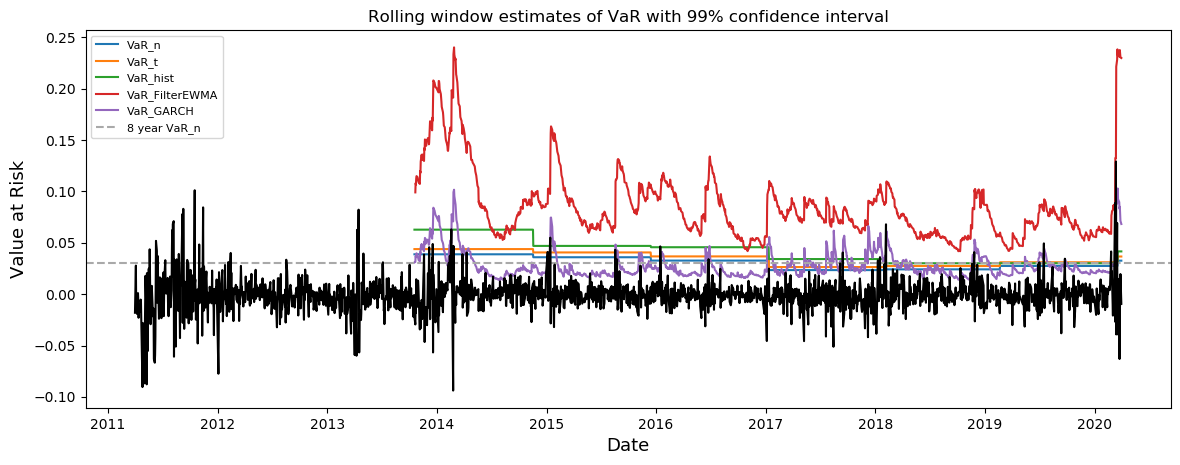

In [59]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
lLegend= list(df.columns[0::2])
lLegend.append("8 year VaR_n")
ten_year_normal = fnVaR_n(df_prices, weights, 0.01, 1508, [True, 0.99], initial_investment)[0]


plt.figure(figsize=(14,5),dpi=100)
plt.plot_date(df.index, df.iloc[:,0::2], linestyle="-", markersize= 0)
plt.axhline(y=ten_year_normal, color= '#A9A9A9', linestyle= "--")
plt.plot_date(df_prices.index, -df_prices['portfolio_return'], linestyle="-", markersize= 0, color= 'k')
plt.xlabel('Date',fontsize=13)
plt.ylabel('Value at Risk',fontsize=13)
plt.title('Rolling window estimates of VaR with 99% confidence interval')
plt.legend(lLegend,loc='upper left',prop={'size': 8})

In [60]:
dfData = df_prices
dfVaR = df
def fnVaRwholeSample(dfVaR, dfData):
    '''
    purpose:
        check the VaR violations for each day for the whole sample
    input:
        dfVaR, dataframe with VaR
        dfData, dataframe of risk factors
    output:
        dfVaR_violation, dataframe with logicals for VaR violations
        True = violation
    '''
    dfVaR_violation= pd.DataFrame(np.zeros((len(dfVaR),5)))
    dfVaR_violation.index = dfVaR.index
    dfVaR_violation.columns= dfVaR.columns[0::2]
    for i in range(5):
        dfVaR_violation.iloc[:,i]= dfData.iloc[-len(dfVaR):,-1] < -dfVaR.iloc[:,i*2]

    return dfVaR_violation

In [61]:
def fnVaRandESyearly(dfData, dfVaR_violation, dfVaR, alpha):
    '''
    purpose:
        calculate the average discrepancy between realized VaR and
        expected VaR for each year. Also, calculate the expected shortfall
        for each year.
    input:
        dfVaR_violation, dataframe of boolanes of VaR violations
        dfVaR, dataframe of VaR
        alpha, significance level
    output:
        dfVaR_violation_year, dataframe of results
    '''
   
    start_year= dfVaR_violation.index[0].year
    end_year= dfVaR_violation.index[-1].year
    # initialize df for output
    dfVaR_violation_year= pd.DataFrame(np.zeros((int(end_year+1)-int(start_year),11)))
    col1= list(dfVaR.columns)
    col1.append("Trading Days")
    dfVaR_violation_year.columns= col1
    dfVaR_violation_year.index= dfVaR_violation.index.to_period("A").unique()
    
    dfVaR_realized= pd.DataFrame(np.zeros((int(end_year+1)-int(start_year),7)))
    dfVaR_realized.columns= ["VaR_n", "VaR_t", "VaR_hist", "VaR_EWMA", "VaR_GARCH","Expected", "Trading Days"]
    dfVaR_realized.index= dfVaR_violation.index.to_period("A").unique()
    
    
    for i, year in enumerate(range(start_year, end_year+1)):
        for type in range(5):
            # calculate VaR violations
            sample= dfVaR_violation[dfVaR_violation.index.year == year].iloc[:,type]
            realized= np.sum(sample)
            expected= len(sample) * alpha
            dfVaR_violation_year.iloc[i,2*type]= realized - expected
            dfVaR_violation_year.iloc[i,10]= len(sample)
            # store the realized and expected number of VaR violations
            dfVaR_realized.iloc[i,type]= realized
            dfVaR_realized.iloc[i,5]= expected
            dfVaR_realized.iloc[i,6]= len(sample)
            # calculate yearly shortfall
            ESsample= dfVaR_violation[dfVaR_violation.index.year == year]
                # select timeframe
            ReturnSample= dfData.loc[ESsample.index]
            #print(ReturnSample)
                # select losses where VaR was violated
            dailyES= -ReturnSample.iloc[:,7][ESsample.iloc[:,type]]
            dfVaR_violation_year.iloc[i,2*type+1]= np.mean(dailyES)
    
    return dfVaR_violation_year, dfVaR_realized

In [62]:
#dfVaR= fnRollingVaR(dfData, weights, alpha, 250, ewma_con, df)
#dfVaR.to_csv("Data/dfVaR_975.csv", index_label= "Date")

# read dfVaR and adjust index
#dfVaR= pd.read_csv("Data/dfVaR_975.csv", index_col= "Date")
alpha = 0.01
#df.index= df.index.to_datetime()

# check number of VaR violations for the whole sample
dfVaR_violation= fnVaRwholeSample(df, df_prices)
print(dfVaR_violation)

# check the number of VaR violations and the ES for each year
dfVaR_violation_year, dfVaR_realized= fnVaRandESyearly(df_prices, dfVaR_violation, df, alpha)


# create df with VaR on violation days
violationVaR= df[dfVaR_violation]

# save csv tables for VaR violations
#dfVaR_realized.to_csv("tables/dfVaR_realized_975.csv")
    # express ES in percentage terms
dfVaR_violation_year.iloc[:,1::2]= dfVaR_violation_year.iloc[:,1::2]*100
dfVaR_violation_year= round(dfVaR_violation_year, 2)
#dfVaR_violation_year.to_csv("tables/VaR_violation_year_975.csv")

            VaR_n  VaR_t  VaR_hist  VaR_FilterEWMA  VaR_GARCH
Date                                                         
2013-10-18  False  False     False           False      False
2013-10-21  False  False     False           False      False
2013-10-22  False  False     False           False      False
2013-10-23  False  False     False           False      False
2013-10-24  False  False     False           False      False
...           ...    ...       ...             ...        ...
2020-03-24  False  False     False           False      False
2020-03-25  False  False     False           False      False
2020-03-26  False  False     False           False      False
2020-03-27  False  False     False           False      False
2020-03-30  False  False     False           False      False

[1508 rows x 5 columns]


In [63]:
print(dfVaR_violation_year)

      VaR_n  ES_n  VaR_t  ES_t  VaR_hist  ES_hist  VaR_FilterEWMA  \
Date                                                                
2013   1.54  4.72   1.54  4.72     -0.46      NaN           -0.46   
2014   1.70  4.73  -0.30  5.50     -1.30     6.30           -2.30   
2015   1.66  4.84   1.66  4.84     -0.34     5.47           -2.34   
2016  -0.36  4.02  -1.36  4.64     -1.36     4.64           -2.36   
2017   1.61  2.98  -0.39  3.53     -1.39     4.05           -2.39   
2018   7.64  3.42   5.64  3.66      0.64     4.82           -2.36   
2019   1.68  3.59  -0.32  4.19      0.68     3.82           -2.32   
2020   4.45  7.15   3.45  8.20      3.45     8.20            0.45   

      ES_FilterEWMA  VaR_GARCH  ES_GARCH  Trading Days  
Date                                                    
2013            NaN      -0.46       NaN          46.0  
2014            NaN       3.70      3.25         230.0  
2015            NaN       1.66      3.97         234.0  
2016            NaN     

In [64]:
print(dfVaR_realized)

      VaR_n  VaR_t  VaR_hist  VaR_EWMA  VaR_GARCH  Expected  Trading Days
Date                                                                     
2013    2.0    2.0       0.0       0.0        0.0      0.46          46.0
2014    4.0    2.0       1.0       0.0        6.0      2.30         230.0
2015    4.0    4.0       2.0       0.0        4.0      2.34         234.0
2016    2.0    1.0       1.0       0.0        2.0      2.36         236.0
2017    4.0    2.0       1.0       0.0        3.0      2.39         239.0
2018   10.0    8.0       3.0       0.0        7.0      2.36         236.0
2019    4.0    2.0       3.0       0.0        3.0      2.32         232.0
2020    5.0    4.0       4.0       1.0        3.0      0.55          55.0


In [65]:
method = ['normal','student t','historical','EWMA','GARCH']

for i in range(len(method)):
    pval = sc.stats.ttest_ind(dfVaR_realized.iloc[:,i],dfVaR_realized.iloc[:,-2])[1]
    tstat = sc.stats.ttest_ind(dfVaR_realized.iloc[:,i],dfVaR_realized.iloc[:,-2])[0]

    print('t-statistics for '+ method[i]+' is %.5f'%(tstat))
    
print('-------')
for i in range(len(method)):
    pval = sc.stats.ttest_ind(dfVaR_realized.iloc[:,i],dfVaR_realized.iloc[:,-2])[1]
    tstat = sc.stats.ttest_ind(dfVaR_realized.iloc[:,i],dfVaR_realized.iloc[:,-2])[0]

    print('p-value for '+ method[i]+' is %.5f'%(pval))

t-statistics for normal is 2.66294
t-statistics for student t is 1.46787
t-statistics for historical is -0.01766
t-statistics for EWMA is -5.39373
t-statistics for GARCH is 1.93307
-------
p-value for normal is 0.01855
p-value for student t is 0.16424
p-value for historical is 0.98616
p-value for EWMA is 0.00009
p-value for GARCH is 0.07371


In [66]:
# print VaR violations for whole time period
print("Normal: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected." % (alpha, np.mean(dfVaR_realized.iloc[:,0]), np.mean(dfVaR_realized.iloc[:,4])))
print("Student-t: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(dfVaR_realized.iloc[:,1]), np.mean(dfVaR_realized.iloc[:,4])))
print("Historical: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(dfVaR_realized.iloc[:,2]), np.mean(dfVaR_realized.iloc[:,4])))
print("EWMA: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(dfVaR_realized.iloc[:,3]), np.mean(dfVaR_realized.iloc[:,4])))
print("GARCH: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(dfVaR_realized.iloc[:,5]), np.mean(dfVaR_realized.iloc[:,4])))

# average discrepancy of VaR violations (realized - expected)
print("Normal: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(dfVaR_violation.iloc[:,0])))
print("Student-t: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(dfVaR_violation.iloc[:,1])))
print("Historical: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(dfVaR_violation.iloc[:,2])))
print("EWMA: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(dfVaR_violation.iloc[:,3])))
print("GARCH: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(dfVaR_violation.iloc[:,4])))


Normal: With alpha 0.01, the average number of violations is 4.38 vs. 3.50 expected.
Student-t: With alpha 0.01, the average number of violations is 3.12 vs. 3.50 expected
Historical: With alpha 0.01, the average number of violations is 1.88 vs. 3.50 expected
EWMA: With alpha 0.01, the average number of violations is 0.12 vs. 3.50 expected
GARCH: With alpha 0.01, the average number of violations is 1.89 vs. 3.50 expected
Normal: With alpha 0.01, the average discrepancy is 0.0232
Student-t: With alpha 0.01, the average discrepancy is 0.0166
Historical: With alpha 0.01, the average discrepancy is 0.0099
EWMA: With alpha 0.01, the average discrepancy is 0.0007
GARCH: With alpha 0.01, the average discrepancy is 0.0186


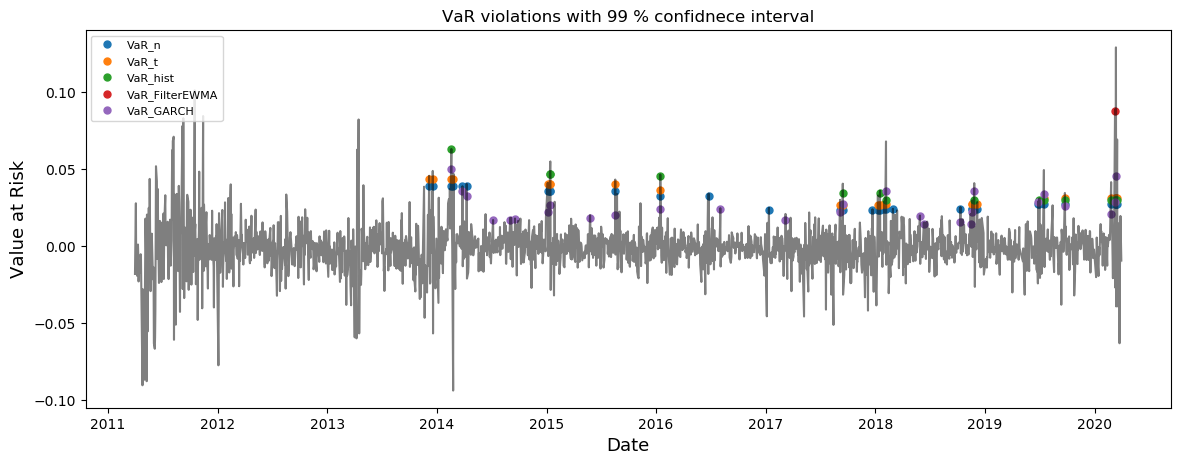

In [67]:
# plot with VaR violations
plt.figure(figsize=(14,5),dpi=100)
plt.plot_date(violationVaR.index, violationVaR.iloc[:,0::2], markersize= 5)
plt.plot_date(dfData.index, -dfData.iloc[:,-1], linestyle="-", markersize= 0, color= 'k', alpha= 0.5)
plt.legend(dfVaR.columns[0::2],loc='upper left',prop={'size': 8})
plt.xlabel('Date',fontsize=13)
plt.ylabel('Value at Risk',fontsize=13)
plt.title('VaR violations with 99 % confidnece interval')
# plt.savefig('plots/violations.png', dpi=300)
plt.show()

In [71]:
df2 = fnRollingVaR(df_prices,weights, 0.025, 500, 0.94, 3, percent=[True, 0.975],para=None,rec=True)
df2.to_csv("01_Data/df_975.csv", index_label= "Date")

/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


( 97.5 %  VaR, ES) in percent is:  nan % nan %
( 97.5 %  VaR, ES) in percent is:  3.25 % 5.94 %
DF= 3
( 97.5 %  VaR, ES) in percent is:  3.04 % 5.56 %
( 97.5 %  VaR, ES) in percent is:  3.23 % 5.94 %
Optimization terminated successfully.
         Current function value: -2.226921
         Iterations: 23
         Function evaluations: 135
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: -1.469701
         Iterations: 22
         Function evaluations: 115
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -3.256902
         Iterations: 22
         Function evaluations: 120
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: -3.249783
         Iterations: 22
         Function evaluations: 115
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -2.867518
         Iterations: 24

( 97.5 %  VaR, ES) in percent is:  10.13 % 14.89 %
( 97.5 %  VaR, ES) in percent is:  3.35 % 4.79 %
( 97.5 %  VaR, ES) in percent is:  10.6 % 15.66 %
( 97.5 %  VaR, ES) in percent is:  3.99 % 5.53 %
( 97.5 %  VaR, ES) in percent is:  10.52 % 15.54 %
( 97.5 %  VaR, ES) in percent is:  3.96 % 5.53 %
( 97.5 %  VaR, ES) in percent is:  10.9 % 16.1 %
( 97.5 %  VaR, ES) in percent is:  4.36 % 5.83 %
( 97.5 %  VaR, ES) in percent is:  10.68 % 15.77 %
( 97.5 %  VaR, ES) in percent is:  4.16 % 5.83 %
( 97.5 %  VaR, ES) in percent is:  13.18 % 19.66 %
( 97.5 %  VaR, ES) in percent is:  6.52 % 8.22 %
( 97.5 %  VaR, ES) in percent is:  13.02 % 19.45 %
( 97.5 %  VaR, ES) in percent is:  6.33 % 8.22 %
( 97.5 %  VaR, ES) in percent is:  12.68 % 18.95 %
( 97.5 %  VaR, ES) in percent is:  5.93 % 6.93 %
( 97.5 %  VaR, ES) in percent is:  15.33 % 23.02 %
( 97.5 %  VaR, ES) in percent is:  8.33 % nan %
( 97.5 %  VaR, ES) in percent is:  15.76 % 23.71 %
( 97.5 %  VaR, ES) in percent is:  8.53 % nan %
( 97.

/home/isualice/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
/home/isualice/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part


( 97.5 %  VaR, ES) in percent is:  14.81 % 22.47 %
( 97.5 %  VaR, ES) in percent is:  7.32 % 8.22 %
( 97.5 %  VaR, ES) in percent is:  14.51 % 21.9 %
( 97.5 %  VaR, ES) in percent is:  6.86 % 8.22 %
( 97.5 %  VaR, ES) in percent is:  13.9 % 21.08 %
( 97.5 %  VaR, ES) in percent is:  6.43 % 8.22 %
( 97.5 %  VaR, ES) in percent is:  13.92 % 20.96 %
( 97.5 %  VaR, ES) in percent is:  6.05 % 6.93 %
( 97.5 %  VaR, ES) in percent is:  13.54 % 20.38 %
( 97.5 %  VaR, ES) in percent is:  5.71 % 6.93 %
( 97.5 %  VaR, ES) in percent is:  13.21 % 19.84 %
( 97.5 %  VaR, ES) in percent is:  5.36 % 6.93 %
( 97.5 %  VaR, ES) in percent is:  12.72 % 19.2 %
( 97.5 %  VaR, ES) in percent is:  5.02 % 6.51 %
( 97.5 %  VaR, ES) in percent is:  12.52 % 18.79 %
( 97.5 %  VaR, ES) in percent is:  4.72 % 6.18 %
( 97.5 %  VaR, ES) in percent is:  12.2 % 18.31 %
( 97.5 %  VaR, ES) in percent is:  4.43 % 5.74 %
( 97.5 %  VaR, ES) in percent is:  12.03 % 18.1 %
( 97.5 %  VaR, ES) in percent is:  4.18 % 5.74 %
( 97.

( 97.5 %  VaR, ES) in percent is:  4.14 % 5.95 %
( 97.5 %  VaR, ES) in percent is:  1.28 % 2.65 %
( 97.5 %  VaR, ES) in percent is:  4.09 % 5.9 %
( 97.5 %  VaR, ES) in percent is:  1.27 % 2.65 %
( 97.5 %  VaR, ES) in percent is:  4.02 % 5.81 %
( 97.5 %  VaR, ES) in percent is:  1.23 % 2.6 %
( 97.5 %  VaR, ES) in percent is:  4.01 % 5.79 %
( 97.5 %  VaR, ES) in percent is:  1.23 % 2.6 %
( 97.5 %  VaR, ES) in percent is:  4.2 % 5.97 %
( 97.5 %  VaR, ES) in percent is:  1.26 % 2.65 %
( 97.5 %  VaR, ES) in percent is:  4.23 % 5.95 %
( 97.5 %  VaR, ES) in percent is:  1.22 % 2.6 %
( 97.5 %  VaR, ES) in percent is:  4.15 % 5.82 %
( 97.5 %  VaR, ES) in percent is:  1.2 % 2.55 %
( 97.5 %  VaR, ES) in percent is:  4.21 % 5.86 %
( 97.5 %  VaR, ES) in percent is:  1.16 % 2.49 %
( 97.5 %  VaR, ES) in percent is:  4.13 % 5.72 %
( 97.5 %  VaR, ES) in percent is:  1.2 % 2.53 %
( 97.5 %  VaR, ES) in percent is:  4.25 % 6.09 %
( 97.5 %  VaR, ES) in percent is:  1.16 % 2.5 %
( 97.5 %  VaR, ES) in percen

( 97.5 %  VaR, ES) in percent is:  7.58 % 10.78 %
( 97.5 %  VaR, ES) in percent is:  2.43 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  7.51 % 10.68 %
( 97.5 %  VaR, ES) in percent is:  3.01 % 4.52 %
DF= 3
( 97.5 %  VaR, ES) in percent is:  2.81 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  3.33 % 4.85 %
Optimization terminated successfully.
         Current function value: -2.624487
         Iterations: 21
         Function evaluations: 110
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: -1.464001
         Iterations: 21
         Function evaluations: 110
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: -3.580910
         Iterations: 25
         Function evaluations: 130
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -3.500883
         Iterations: 29
         Function evaluations: 150
         Gradient evaluations: 30
Op

( 97.5 %  VaR, ES) in percent is:  7.07 % 10.28 %
( 97.5 %  VaR, ES) in percent is:  1.87 % 3.78 %
( 97.5 %  VaR, ES) in percent is:  6.96 % 10.05 %
( 97.5 %  VaR, ES) in percent is:  1.75 % 3.46 %
( 97.5 %  VaR, ES) in percent is:  6.82 % 9.89 %
( 97.5 %  VaR, ES) in percent is:  1.66 % 3.25 %
( 97.5 %  VaR, ES) in percent is:  6.8 % 9.81 %
( 97.5 %  VaR, ES) in percent is:  1.67 % 3.33 %
( 97.5 %  VaR, ES) in percent is:  6.66 % 9.61 %
( 97.5 %  VaR, ES) in percent is:  1.63 % 3.17 %
( 97.5 %  VaR, ES) in percent is:  6.51 % 9.45 %
( 97.5 %  VaR, ES) in percent is:  1.58 % 3.11 %
( 97.5 %  VaR, ES) in percent is:  7.06 % 10.33 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.24 %
( 97.5 %  VaR, ES) in percent is:  7.07 % 10.24 %
( 97.5 %  VaR, ES) in percent is:  2.28 % 4.03 %
( 97.5 %  VaR, ES) in percent is:  6.88 % 10.02 %
( 97.5 %  VaR, ES) in percent is:  2.09 % 3.97 %
( 97.5 %  VaR, ES) in percent is:  6.85 % 9.93 %
( 97.5 %  VaR, ES) in percent is:  1.96 % 3.84 %
( 97.5 %  VaR, E

( 97.5 %  VaR, ES) in percent is:  5.49 % 7.73 %
( 97.5 %  VaR, ES) in percent is:  1.63 % 2.9 %
( 97.5 %  VaR, ES) in percent is:  5.38 % 7.58 %
( 97.5 %  VaR, ES) in percent is:  1.58 % 2.84 %
( 97.5 %  VaR, ES) in percent is:  5.29 % 7.45 %
( 97.5 %  VaR, ES) in percent is:  1.54 % 2.78 %
( 97.5 %  VaR, ES) in percent is:  5.15 % 7.26 %
( 97.5 %  VaR, ES) in percent is:  1.5 % 2.72 %
( 97.5 %  VaR, ES) in percent is:  5.29 % 7.45 %
( 97.5 %  VaR, ES) in percent is:  1.67 % 3.05 %
( 97.5 %  VaR, ES) in percent is:  5.25 % 7.41 %
( 97.5 %  VaR, ES) in percent is:  1.64 % 2.97 %
( 97.5 %  VaR, ES) in percent is:  5.15 % 7.27 %
( 97.5 %  VaR, ES) in percent is:  1.59 % 2.84 %
( 97.5 %  VaR, ES) in percent is:  5.05 % 7.13 %
( 97.5 %  VaR, ES) in percent is:  1.56 % 2.81 %
( 97.5 %  VaR, ES) in percent is:  4.94 % 6.98 %
( 97.5 %  VaR, ES) in percent is:  1.5 % 2.72 %
( 97.5 %  VaR, ES) in percent is:  4.84 % 6.84 %
( 97.5 %  VaR, ES) in percent is:  1.47 % 2.7 %
( 97.5 %  VaR, ES) in pe

( 97.5 %  VaR, ES) in percent is:  7.15 % 10.5 %
( 97.5 %  VaR, ES) in percent is:  1.89 % 3.41 %
( 97.5 %  VaR, ES) in percent is:  6.94 % 10.29 %
( 97.5 %  VaR, ES) in percent is:  1.85 % 3.36 %
( 97.5 %  VaR, ES) in percent is:  7.05 % 10.75 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 3.91 %
( 97.5 %  VaR, ES) in percent is:  7.04 % 10.71 %
( 97.5 %  VaR, ES) in percent is:  2.39 % 3.91 %
( 97.5 %  VaR, ES) in percent is:  7.08 % 10.8 %
( 97.5 %  VaR, ES) in percent is:  2.35 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  6.93 % 10.53 %
( 97.5 %  VaR, ES) in percent is:  2.18 % 3.74 %
( 97.5 %  VaR, ES) in percent is:  7.74 % 11.6 %
( 97.5 %  VaR, ES) in percent is:  2.5 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  7.84 % 11.74 %
( 97.5 %  VaR, ES) in percent is:  2.36 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  8.12 % 12.16 %
( 97.5 %  VaR, ES) in percent is:  2.71 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  8.08 % 12.11 %
( 97.5 %  VaR, ES) in percent is:  2.66 % 4.04 %
( 97.5 %  VaR,

( 97.5 %  VaR, ES) in percent is:  6.57 % 9.48 %
( 97.5 %  VaR, ES) in percent is:  1.64 % 2.97 %
( 97.5 %  VaR, ES) in percent is:  6.38 % 9.23 %
( 97.5 %  VaR, ES) in percent is:  1.57 % 2.85 %
( 97.5 %  VaR, ES) in percent is:  6.24 % 9.01 %
( 97.5 %  VaR, ES) in percent is:  1.53 % 2.81 %
( 97.5 %  VaR, ES) in percent is:  6.26 % 9.03 %
( 97.5 %  VaR, ES) in percent is:  1.89 % 3.61 %
( 97.5 %  VaR, ES) in percent is:  6.33 % 9.12 %
( 97.5 %  VaR, ES) in percent is:  1.95 % 3.61 %
( 97.5 %  VaR, ES) in percent is:  6.25 % 9.01 %
( 97.5 %  VaR, ES) in percent is:  1.74 % 3.05 %
( 97.5 %  VaR, ES) in percent is:  6.11 % 8.81 %
( 97.5 %  VaR, ES) in percent is:  1.62 % 2.92 %
( 97.5 %  VaR, ES) in percent is:  5.98 % 8.63 %
( 97.5 %  VaR, ES) in percent is:  1.68 % 2.97 %
( 97.5 %  VaR, ES) in percent is:  5.86 % 8.43 %
( 97.5 %  VaR, ES) in percent is:  1.58 % 2.85 %
( 97.5 %  VaR, ES) in percent is:  5.71 % 8.23 %
( 97.5 %  VaR, ES) in percent is:  1.52 % 2.81 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  7.23 % 10.73 %
( 97.5 %  VaR, ES) in percent is:  1.68 % 2.66 %
( 97.5 %  VaR, ES) in percent is:  6.89 % 10.26 %
( 97.5 %  VaR, ES) in percent is:  1.62 % 2.56 %
( 97.5 %  VaR, ES) in percent is:  6.87 % 10.19 %
( 97.5 %  VaR, ES) in percent is:  1.59 % 2.56 %
( 97.5 %  VaR, ES) in percent is:  6.6 % 9.79 %
( 97.5 %  VaR, ES) in percent is:  1.55 % 2.56 %
( 97.5 %  VaR, ES) in percent is:  6.49 % 9.67 %
( 97.5 %  VaR, ES) in percent is:  1.51 % 2.54 %
( 97.5 %  VaR, ES) in percent is:  6.38 % 9.58 %
( 97.5 %  VaR, ES) in percent is:  1.48 % 2.51 %
( 97.5 %  VaR, ES) in percent is:  6.69 % 10.25 %
( 97.5 %  VaR, ES) in percent is:  2.02 % 3.64 %
( 97.5 %  VaR, ES) in percent is:  7.32 % 10.89 %
( 97.5 %  VaR, ES) in percent is:  2.59 % 3.94 %
( 97.5 %  VaR, ES) in percent is:  7.27 % 10.85 %
( 97.5 %  VaR, ES) in percent is:  2.5 % 3.94 %
( 97.5 %  VaR, ES) in percent is:  7.17 % 10.84 %
( 97.5 %  VaR, ES) in percent is:  2.33 % 3.81 %
( 97.5 %  VaR, 

( 97.5 %  VaR, ES) in percent is:  3.72 % 5.91 %
( 97.5 %  VaR, ES) in percent is:  1.56 % 2.78 %
( 97.5 %  VaR, ES) in percent is:  3.76 % 5.96 %
( 97.5 %  VaR, ES) in percent is:  1.55 % 2.78 %
( 97.5 %  VaR, ES) in percent is:  3.78 % 5.98 %
( 97.5 %  VaR, ES) in percent is:  1.53 % 2.78 %
( 97.5 %  VaR, ES) in percent is:  3.75 % 5.98 %
( 97.5 %  VaR, ES) in percent is:  1.55 % 2.78 %
( 97.5 %  VaR, ES) in percent is:  3.73 % 5.95 %
( 97.5 %  VaR, ES) in percent is:  1.56 % 2.78 %
( 97.5 %  VaR, ES) in percent is:  3.7 % 5.88 %
( 97.5 %  VaR, ES) in percent is:  1.52 % 2.78 %
( 97.5 %  VaR, ES) in percent is:  3.75 % 5.81 %
( 97.5 %  VaR, ES) in percent is:  1.51 % 2.78 %
( 97.5 %  VaR, ES) in percent is:  3.68 % 5.7 %
( 97.5 %  VaR, ES) in percent is:  1.49 % 2.73 %
( 97.5 %  VaR, ES) in percent is:  3.64 % 5.62 %
( 97.5 %  VaR, ES) in percent is:  1.46 % 2.73 %
( 97.5 %  VaR, ES) in percent is:  3.59 % 5.53 %
( 97.5 %  VaR, ES) in percent is:  1.44 % 2.73 %
( 97.5 %  VaR, ES) in 

( 97.5 %  VaR, ES) in percent is:  5.35 % 8.79 %
( 97.5 %  VaR, ES) in percent is:  2.22 % 3.18 %
( 97.5 %  VaR, ES) in percent is:  5.48 % 9.03 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 3.58 %
( 97.5 %  VaR, ES) in percent is:  5.53 % 9.07 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 3.3 %
( 97.5 %  VaR, ES) in percent is:  5.66 % 9.31 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 3.58 %
( 97.5 %  VaR, ES) in percent is:  5.52 % 9.06 %
( 97.5 %  VaR, ES) in percent is:  2.26 % 3.3 %
( 97.5 %  VaR, ES) in percent is:  5.77 % 9.56 %
( 97.5 %  VaR, ES) in percent is:  2.79 % 3.74 %
( 97.5 %  VaR, ES) in percent is:  6.2 % 10.29 %
( 97.5 %  VaR, ES) in percent is:  3.34 % 3.94 %
( 97.5 %  VaR, ES) in percent is:  6.05 % 9.99 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 3.94 %
( 97.5 %  VaR, ES) in percent is:  5.93 % 9.9 %
( 97.5 %  VaR, ES) in percent is:  2.69 % 3.58 %
( 97.5 %  VaR, ES) in percent is:  5.85 % 9.72 %
( 97.5 %  VaR, ES) in percent is:  2.55 % 3.58 %
( 97.5 %  VaR, ES) in p

( 97.5 %  VaR, ES) in percent is:  5.62 % 9.47 %
( 97.5 %  VaR, ES) in percent is:  3.13 % 3.94 %
( 97.5 %  VaR, ES) in percent is:  5.59 % 9.19 %
( 97.5 %  VaR, ES) in percent is:  2.99 % 3.94 %
( 97.5 %  VaR, ES) in percent is:  5.3 % 10.23 %
( 97.5 %  VaR, ES) in percent is:  2.85 % 3.74 %
( 97.5 %  VaR, ES) in percent is:  4.88 % 7.88 %
( 97.5 %  VaR, ES) in percent is:  2.62 % 3.58 %
( 97.5 %  VaR, ES) in percent is:  4.85 % 7.59 %
( 97.5 %  VaR, ES) in percent is:  2.58 % 3.58 %
( 97.5 %  VaR, ES) in percent is:  4.73 % 7.47 %
( 97.5 %  VaR, ES) in percent is:  2.33 % 3.3 %
( 97.5 %  VaR, ES) in percent is:  4.65 % 7.33 %
( 97.5 %  VaR, ES) in percent is:  2.19 % 3.18 %
( 97.5 %  VaR, ES) in percent is:  4.59 % 7.18 %
( 97.5 %  VaR, ES) in percent is:  2.09 % 3.08 %
( 97.5 %  VaR, ES) in percent is:  5.1 % 8.05 %
( 97.5 %  VaR, ES) in percent is:  3.45 % 4.48 %
( 97.5 %  VaR, ES) in percent is:  4.98 % 7.89 %
( 97.5 %  VaR, ES) in percent is:  3.08 % 3.94 %
( 97.5 %  VaR, ES) in 

( 97.5 %  VaR, ES) in percent is:  4.77 % 7.36 %
( 97.5 %  VaR, ES) in percent is:  2.72 % 3.47 %
( 97.5 %  VaR, ES) in percent is:  4.79 % 7.47 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 3.47 %
( 97.5 %  VaR, ES) in percent is:  4.8 % 7.49 %
( 97.5 %  VaR, ES) in percent is:  2.74 % 3.47 %
( 97.5 %  VaR, ES) in percent is:  4.68 % 7.27 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 3.47 %
( 97.5 %  VaR, ES) in percent is:  5.44 % 8.43 %
( 97.5 %  VaR, ES) in percent is:  4.05 % 4.35 %
( 97.5 %  VaR, ES) in percent is:  6.27 % 9.92 %
( 97.5 %  VaR, ES) in percent is:  5.56 % nan %
( 97.5 %  VaR, ES) in percent is:  6.26 % 9.91 %
( 97.5 %  VaR, ES) in percent is:  5.14 % nan %
( 97.5 %  VaR, ES) in percent is:  6.17 % 9.77 %
( 97.5 %  VaR, ES) in percent is:  4.6 % 4.64 %
( 97.5 %  VaR, ES) in percent is:  6.11 % 9.68 %
( 97.5 %  VaR, ES) in percent is:  4.14 % 4.64 %
( 97.5 %  VaR, ES) in percent is:  6.11 % 9.7 %
( 97.5 %  VaR, ES) in percent is:  3.9 % 4.35 %
( 97.5 %  VaR, ES) in perc

( 97.5 %  VaR, ES) in percent is:  5.42 % 8.4 %
( 97.5 %  VaR, ES) in percent is:  2.12 % 3.16 %
( 97.5 %  VaR, ES) in percent is:  5.44 % 8.42 %
( 97.5 %  VaR, ES) in percent is:  2.12 % 3.16 %
( 97.5 %  VaR, ES) in percent is:  5.6 % 8.62 %
( 97.5 %  VaR, ES) in percent is:  2.12 % 3.16 %
( 97.5 %  VaR, ES) in percent is:  5.68 % 8.74 %
( 97.5 %  VaR, ES) in percent is:  2.44 % 3.49 %
( 97.5 %  VaR, ES) in percent is:  5.69 % 8.78 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 3.49 %
( 97.5 %  VaR, ES) in percent is:  5.57 % 8.59 %
( 97.5 %  VaR, ES) in percent is:  2.24 % 3.23 %
( 97.5 %  VaR, ES) in percent is:  5.77 % 8.87 %
( 97.5 %  VaR, ES) in percent is:  2.75 % 3.75 %
( 97.5 %  VaR, ES) in percent is:  5.7 % 8.79 %
( 97.5 %  VaR, ES) in percent is:  2.58 % 3.75 %
( 97.5 %  VaR, ES) in percent is:  5.69 % 8.78 %
( 97.5 %  VaR, ES) in percent is:  2.55 % 3.75 %
( 97.5 %  VaR, ES) in percent is:  5.73 % 8.84 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 3.75 %
( 97.5 %  VaR, ES) in p

( 97.5 %  VaR, ES) in percent is:  4.56 % 6.93 %
( 97.5 %  VaR, ES) in percent is:  2.33 % 3.31 %
( 97.5 %  VaR, ES) in percent is:  4.45 % 6.77 %
( 97.5 %  VaR, ES) in percent is:  2.19 % 3.23 %
( 97.5 %  VaR, ES) in percent is:  4.42 % 6.64 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 3.09 %
( 97.5 %  VaR, ES) in percent is:  4.29 % 6.5 %
( 97.5 %  VaR, ES) in percent is:  1.93 % 2.9 %
( 97.5 %  VaR, ES) in percent is:  4.33 % 6.55 %
( 97.5 %  VaR, ES) in percent is:  1.99 % 2.93 %
( 97.5 %  VaR, ES) in percent is:  4.29 % 6.45 %
( 97.5 %  VaR, ES) in percent is:  1.88 % 2.82 %
( 97.5 %  VaR, ES) in percent is:  4.19 % 6.32 %
( 97.5 %  VaR, ES) in percent is:  1.76 % 2.6 %
( 97.5 %  VaR, ES) in percent is:  4.09 % 6.16 %
( 97.5 %  VaR, ES) in percent is:  1.66 % 2.49 %
( 97.5 %  VaR, ES) in percent is:  4.14 % 6.25 %
( 97.5 %  VaR, ES) in percent is:  1.93 % 2.87 %
( 97.5 %  VaR, ES) in percent is:  4.07 % 6.15 %
( 97.5 %  VaR, ES) in percent is:  1.86 % 2.72 %
( 97.5 %  VaR, ES) in p

( 97.5 %  VaR, ES) in percent is:  6.43 % 9.43 %
( 97.5 %  VaR, ES) in percent is:  4.25 % 6.79 %
( 97.5 %  VaR, ES) in percent is:  6.25 % 9.15 %
( 97.5 %  VaR, ES) in percent is:  3.88 % 4.98 %
( 97.5 %  VaR, ES) in percent is:  6.2 % 8.99 %
( 97.5 %  VaR, ES) in percent is:  3.73 % 4.98 %
( 97.5 %  VaR, ES) in percent is:  6.15 % 9.01 %
( 97.5 %  VaR, ES) in percent is:  3.47 % 4.63 %
( 97.5 %  VaR, ES) in percent is:  6.18 % 9.07 %
( 97.5 %  VaR, ES) in percent is:  3.33 % 4.63 %
( 97.5 %  VaR, ES) in percent is:  6.45 % 9.39 %
( 97.5 %  VaR, ES) in percent is:  3.7 % 4.98 %
( 97.5 %  VaR, ES) in percent is:  6.37 % 9.36 %
( 97.5 %  VaR, ES) in percent is:  3.48 % 4.63 %
( 97.5 %  VaR, ES) in percent is:  6.29 % 9.3 %
( 97.5 %  VaR, ES) in percent is:  3.22 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  6.14 % 9.04 %
( 97.5 %  VaR, ES) in percent is:  2.98 % 4.13 %
( 97.5 %  VaR, ES) in percent is:  6.1 % 8.98 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 3.64 %
( 97.5 %  VaR, ES) in pe

( 97.5 %  VaR, ES) in percent is:  3.21 % 4.56 %
( 97.5 %  VaR, ES) in percent is:  1.52 % 2.28 %
( 97.5 %  VaR, ES) in percent is:  3.22 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  1.53 % 2.33 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 4.58 %
( 97.5 %  VaR, ES) in percent is:  1.56 % 2.33 %
( 97.5 %  VaR, ES) in percent is:  3.22 % 4.57 %
( 97.5 %  VaR, ES) in percent is:  1.56 % 2.33 %
( 97.5 %  VaR, ES) in percent is:  3.12 % 4.48 %
( 97.5 %  VaR, ES) in percent is:  1.54 % 2.33 %
( 97.5 %  VaR, ES) in percent is:  3.12 % 4.48 %
( 97.5 %  VaR, ES) in percent is:  1.56 % 2.33 %
( 97.5 %  VaR, ES) in percent is:  4.3 % 6.15 %
( 97.5 %  VaR, ES) in percent is:  2.4 % 3.44 %
( 97.5 %  VaR, ES) in percent is:  4.27 % 6.11 %
( 97.5 %  VaR, ES) in percent is:  2.32 % 3.36 %
( 97.5 %  VaR, ES) in percent is:  4.17 % 5.96 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 3.29 %
( 97.5 %  VaR, ES) in percent is:  4.08 % 5.83 %
( 97.5 %  VaR, ES) in percent is:  2.14 % 3.21 %
( 97.5 %  VaR, ES) in p

( 97.5 %  VaR, ES) in percent is:  6.4 % 8.97 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 3.64 %
( 97.5 %  VaR, ES) in percent is:  6.36 % 8.92 %
( 97.5 %  VaR, ES) in percent is:  2.5 % 3.56 %
( 97.5 %  VaR, ES) in percent is:  6.24 % 8.75 %
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.56 %
( 97.5 %  VaR, ES) in percent is:  6.12 % 8.61 %
( 97.5 %  VaR, ES) in percent is:  2.34 % 3.41 %
( 97.5 %  VaR, ES) in percent is:  6.01 % 8.43 %
( 97.5 %  VaR, ES) in percent is:  2.24 % 3.35 %
( 97.5 %  VaR, ES) in percent is:  6.22 % 8.72 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 3.41 %
( 97.5 %  VaR, ES) in percent is:  6.45 % 9.02 %
( 97.5 %  VaR, ES) in percent is:  2.55 % 3.57 %
( 97.5 %  VaR, ES) in percent is:  6.52 % 9.09 %
( 97.5 %  VaR, ES) in percent is:  2.47 % 3.5 %
( 97.5 %  VaR, ES) in percent is:  6.29 % 8.78 %
( 97.5 %  VaR, ES) in percent is:  2.37 % 3.37 %
( 97.5 %  VaR, ES) in percent is:  6.27 % 8.73 %
( 97.5 %  VaR, ES) in percent is:  2.35 % 3.37 %
( 97.5 %  VaR, ES) in pe

( 97.5 %  VaR, ES) in percent is:  3.59 % 5.18 %
( 97.5 %  VaR, ES) in percent is:  1.64 % 2.57 %
( 97.5 %  VaR, ES) in percent is:  3.58 % 5.14 %
( 97.5 %  VaR, ES) in percent is:  1.63 % 2.54 %
( 97.5 %  VaR, ES) in percent is:  3.73 % 5.43 %
( 97.5 %  VaR, ES) in percent is:  1.61 % 2.52 %
( 97.5 %  VaR, ES) in percent is:  3.8 % 5.53 %
( 97.5 %  VaR, ES) in percent is:  1.69 % 2.62 %
( 97.5 %  VaR, ES) in percent is:  3.8 % 5.56 %
( 97.5 %  VaR, ES) in percent is:  1.73 % 2.69 %
( 97.5 %  VaR, ES) in percent is:  4.12 % 6.05 %
( 97.5 %  VaR, ES) in percent is:  1.98 % 3.11 %
( 97.5 %  VaR, ES) in percent is:  4.02 % 5.89 %
( 97.5 %  VaR, ES) in percent is:  1.92 % 3.0 %
( 97.5 %  VaR, ES) in percent is:  3.92 % 5.76 %
( 97.5 %  VaR, ES) in percent is:  1.87 % 2.91 %
( 97.5 %  VaR, ES) in percent is:  3.84 % 5.64 %
( 97.5 %  VaR, ES) in percent is:  1.82 % 2.87 %
( 97.5 %  VaR, ES) in percent is:  3.78 % 5.57 %
( 97.5 %  VaR, ES) in percent is:  1.79 % 2.79 %
( 97.5 %  VaR, ES) in p

( 97.5 %  VaR, ES) in percent is:  2.54 % 4.21 %


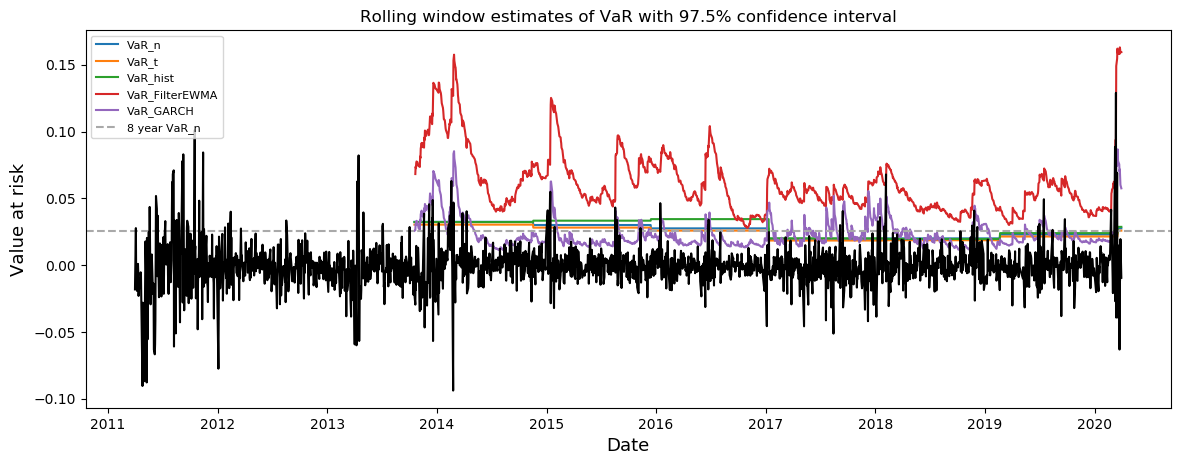

In [72]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
lLegend= list(df2.columns[0::2])
lLegend.append("8 year VaR_n")
ten_year_normal = fnVaR_n(df_prices, weights, 0.025,1508, [True, 0.975], initial_investment)[0]

plt.figure(figsize=(14,5),dpi=100)
plt.plot_date(df2.index, df2.iloc[:,0::2], linestyle="-", markersize= 0)
plt.axhline(ten_year_normal, color= '#A9A9A9', linestyle= "--")
plt.plot_date(df_prices.index, -df_prices['portfolio_return'], linestyle="-", markersize= 0, color= 'k')
plt.xlabel('Date',fontsize=13)
plt.ylabel('Value at risk',fontsize=13)
plt.title('Rolling window estimates of VaR with 97.5% confidence interval')
plt.legend(lLegend,loc='upper left',prop={'size': 8})

In [73]:

df2VaR = df2

alpha = 0.025
#df2.index= df2.index.to_datetime()

# check number of VaR violations for the whole sample
df2VaR_violation= fnVaRwholeSample(df2, df_prices)
#print(df2VaR_violation)

# check the number of VaR violations and the ES for each year
df2VaR_violation_year, df2VaR_realized= fnVaRandESyearly(df_prices, df2VaR_violation, df2, alpha)


# create df2 with VaR on violation days
violationVaR= df2[df2VaR_violation]


df2VaR_violation_year.iloc[:,1::2]= df2VaR_violation_year.iloc[:,1::2]*100
df2VaR_violation_year= round(df2VaR_violation_year, 2)


In [74]:
print(df2VaR_violation_year)

      VaR_n  ES_n  VaR_t  ES_t  VaR_hist  ES_hist  VaR_FilterEWMA  \
Date                                                                
2013   2.85  4.20   2.85  4.20      2.85     4.20           -1.15   
2014  -0.75  4.52   1.25  4.11     -0.75     4.52           -5.75   
2015  -0.85  4.55   0.15  4.27     -0.85     4.55           -5.85   
2016  -2.90  3.67  -2.90  3.67     -4.90     4.64           -5.90   
2017   1.02  2.60   2.02  2.51      1.02     2.60           -5.98   
2018   7.10  3.13  10.10  2.91      8.10     3.05           -4.90   
2019  -0.80  3.40   0.20  3.15     -0.80     3.40           -5.80   
2020   3.62  7.15   4.62  6.34      3.62     7.15            1.62   

      ES_FilterEWMA  VaR_GARCH  ES_GARCH  Trading Days  
Date                                                    
2013            NaN       0.85      4.21          46.0  
2014            NaN       7.25      2.50         230.0  
2015            NaN       1.15      3.93         234.0  
2016            NaN     

In [75]:
df2VaR_realized

,VaR_n,VaR_t,VaR_hist,VaR_EWMA,VaR_GARCH,Expected,Trading Days
Date,,,,,,,
2013,4.0,4.0,4.0,0.0,2.0,1.150,46.0
2014,5.0,7.0,5.0,0.0,13.0,5.750,230.0
2015,5.0,6.0,5.0,0.0,7.0,5.850,234.0
2016,3.0,3.0,1.0,0.0,3.0,5.900,236.0
2017,7.0,8.0,7.0,0.0,5.0,5.975,239.0
2018,13.0,16.0,14.0,1.0,12.0,5.900,236.0
2019,5.0,6.0,5.0,0.0,5.0,5.800,232.0
2020,5.0,6.0,5.0,3.0,3.0,1.375,55.0


In [76]:
method = ['normal','student t','historical','EWMA','GARCH']

for i in range(len(method)):
    pval = sc.stats.ttest_ind(df2VaR_realized.iloc[:,i],df2VaR_realized.iloc[:,-2])[1]
    tstat = sc.stats.ttest_ind(df2VaR_realized.iloc[:,i],df2VaR_realized.iloc[:,-2])[0]

    print('t-statistics for '+ method[i]+' is %.5f'%(tstat))
    
print('-------')
for i in range(len(method)):
    pval = sc.stats.ttest_ind(df2VaR_realized.iloc[:,i],df2VaR_realized.iloc[:,-2])[1]
    tstat = sc.stats.ttest_ind(df2VaR_realized.iloc[:,i],df2VaR_realized.iloc[:,-2])[0]

    print('p-value for '+ method[i]+' is %.5f'%(pval))

t-statistics for normal is 0.87577
t-statistics for student t is 1.43754
t-statistics for historical is 0.68279
t-statistics for EWMA is -4.99696
t-statistics for GARCH is 0.92927
-------
p-value for normal is 0.39593
p-value for student t is 0.17254
p-value for historical is 0.50588
p-value for EWMA is 0.00020
p-value for GARCH is 0.36850


In [77]:
# print VaR violations for whole time period
print("Normal: With alpha %.3f, the average number of violations is %.2f vs. %.2f expected." % (alpha, np.mean(df2VaR_realized.iloc[:,0]), np.mean(df2VaR_realized.iloc[:,4])))
print("Student-t: With alpha %.3f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(df2VaR_realized.iloc[:,1]), np.mean(df2VaR_realized.iloc[:,4])))
print("Historical: With alpha %.3f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(df2VaR_realized.iloc[:,2]), np.mean(df2VaR_realized.iloc[:,4])))
print("EWMA: With alpha %.3f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(df2VaR_realized.iloc[:,3]), np.mean(df2VaR_realized.iloc[:,4])))
print("GARCH: With alpha %.3f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(df2VaR_realized.iloc[:,5]), np.mean(df2VaR_realized.iloc[:,4])))

# average discrepancy of VaR violations (realized - expected)
print("Normal: With alpha %.3f, the average discrepancy is %.4f" % (alpha, np.mean(df2VaR_violation.iloc[:,0])))
print("Student-t: With alpha %.3f, the average discrepancy is %.4f" % (alpha, np.mean(df2VaR_violation.iloc[:,1])))
print("Historical: With alpha %.3f, the average discrepancy is %.4f" % (alpha, np.mean(df2VaR_violation.iloc[:,2])))
print("EWMA: With alpha %.3f, the average discrepancy is %.4f" % (alpha, np.mean(df2VaR_violation.iloc[:,3])))
print("GARCH: With alpha %.3f, the average discrepancy is %.4f" % (alpha, np.mean(df2VaR_violation.iloc[:,4])))

Normal: With alpha 0.025, the average number of violations is 5.88 vs. 6.25 expected.
Student-t: With alpha 0.025, the average number of violations is 7.00 vs. 6.25 expected
Historical: With alpha 0.025, the average number of violations is 5.75 vs. 6.25 expected
EWMA: With alpha 0.025, the average number of violations is 0.50 vs. 6.25 expected
GARCH: With alpha 0.025, the average number of violations is 4.71 vs. 6.25 expected
Normal: With alpha 0.025, the average discrepancy is 0.0312
Student-t: With alpha 0.025, the average discrepancy is 0.0371
Historical: With alpha 0.025, the average discrepancy is 0.0305
EWMA: With alpha 0.025, the average discrepancy is 0.0027
GARCH: With alpha 0.025, the average discrepancy is 0.0332


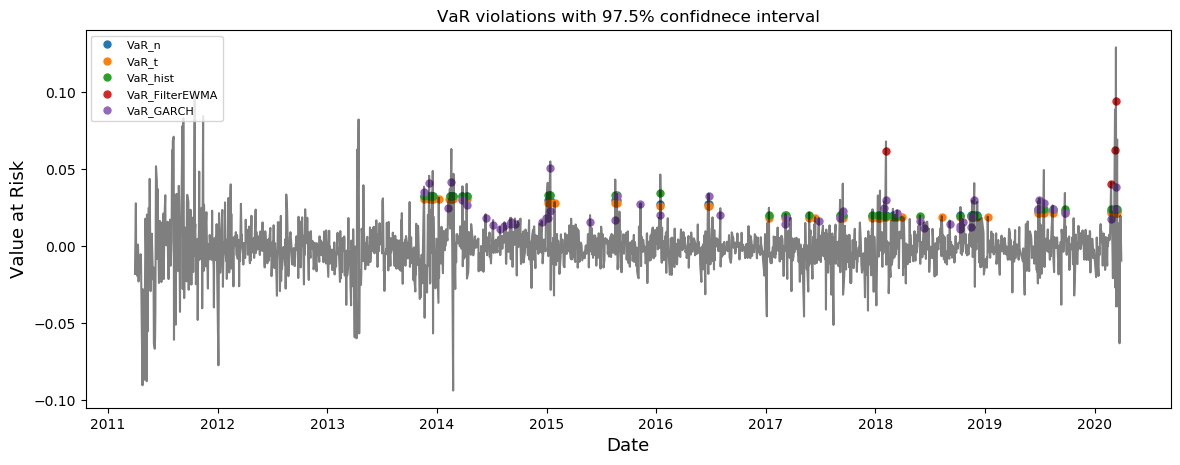

In [78]:
# plot with VaR violations
plt.figure(figsize=(14,5),dpi=100)
plt.plot_date(violationVaR.index, violationVaR.iloc[:,0::2], markersize= 5)
plt.plot_date(dfData.index, -dfData.iloc[:,-1], linestyle="-", markersize= 0, color= 'k', alpha= 0.5)
plt.legend(df2VaR.columns[0::2],loc='upper left',prop={'size': 8})
plt.xlabel('Date',fontsize=13)
plt.ylabel('Value at Risk',fontsize=13)
plt.title('VaR violations with 97.5% confidnece interval')
# plt.savefig('plots/violations.png', dpi=300)
plt.show()

### Empirical 5- and 10-days VaRs

In [68]:
initial_investment = 1000000
data = df_prices.iloc[7:,:]
lookback = len(data)
df = 3
# 5-day VaR
df5=   data.groupby(np.arange(len( data))//5).sum()
df5.index=  data.index[::5]
lookback5= lookback//5 # set lookback for 5 day VaR
# 10-day VaR   
df10=  data.groupby(np.arange(len( data))//10).sum()
df10.index=  data.index[::10]
lookback10= lookback//10 # set lookback for 10 day VaR

Methods= ["Normal", "Student-t", "Historical","GARCH"]
Cols= ["5d_99","sq5d_99","10d_99","sq10d_99","5d_975","sq5d_975","10d_975","sq10d_975"]
dfEmpirical= pd.DataFrame(np.zeros((len(Methods),len(Cols))), index = Methods, columns= Cols)

alpha_x= np.array([0.01,0.025 ])                                  # Different confidences
lookback_x= np.array([lookback5, lookback, lookback10, lookback])   # Compare with sqrt time
df1=  data.copy()
dfx= pd.DataFrame([df5, df1, df10, df1])
print(dfx.iloc[1:0])
for i in range(len(alpha_x)): 
    percent = [True,1-alpha_x[i]] 
    for j in range(len(lookback_x)):
        dfEmpirical.iloc[0,j+4*i], null= fnVaR_n(dfx.iloc[j,0], weights, alpha_x[i], lookback_x[j], percent,initial_investment)
        dfEmpirical.iloc[1,j+4*i], null= fnVaR_t(dfx.iloc[j,0], weights, lookback_x[j],df, alpha_x[i], percent, initial_investment)
        dfEmpirical.iloc[2,j+4*i], null= fnVaR_hist(dfx.iloc[j,0], weights, alpha_x[i], lookback_x[j], percent,initial_investment)
        #dfEmpirical.iloc[3,j+4*i], null= fnVaR_FilterEWMA(dfx.iloc[j,0], weights2, 0.94, alpha_x[i], lookback_x[j], percent,initial_investment)
        garch = fnVaR_GARCH(dfx.iloc[j,0], weights, alpha_x[i], lookback_x[j], percent,initial_investment,para=None,Variances=None,rec=True)
        dfEmpirical.iloc[3,j+4*i], null = garch[0],garch[1]
        if j == 1:
            dfEmpirical.iloc[:,j+4*i]= dfEmpirical.iloc[:,j+4*i]*np.sqrt(5)
        elif j == 3:
            dfEmpirical.iloc[:,j+4*i]= dfEmpirical.iloc[:,j+4*i]*np.sqrt(10)
# Convert output based on whether its df_prices.iloc[1:,:] or portfolio value
if percent[0] == False:
    dfEmpirical= (dfEmpirical*initial_investment).round(-1).astype(int)
else:
    dfEmpirical= (dfEmpirical*100).round(2)  
#dfEmpirical.to_csv("Tables/dfEmpiricalPercentages.csv", index_label= "Method")

Empty DataFrame
Columns: [0]
Index: []
( 99.0 %  VaR, ES) in percent is:  8.87 % 12.46 %
DF= 3
( 99.0 %  VaR, ES) in percent is:  10.03 % 12.79 %
( 99.0 %  VaR, ES) in percent is:  12.3 % 14.67 %
Optimization terminated successfully.
         Current function value: -1.863199
         Iterations: 19
         Function evaluations: 100
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -0.613423
         Iterations: 16
         Function evaluations: 90
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: -2.379080
         Iterations: 24
         Function evaluations: 135
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: -2.576542
         Iterations: 21
         Function evaluations: 110
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: -2.185416
         Iterations: 22
    

Optimization terminated successfully.
         Current function value: -3.746782
         Iterations: 23
         Function evaluations: 120
         Gradient evaluations: 24
( 97.5 %  VaR, ES) in percent is:  5.28 % 7.62 %
( 97.5 %  VaR, ES) in percent is:  9.46 % 14.4 %
DF= 3
( 97.5 %  VaR, ES) in percent is:  8.84 % 14.4 %
( 97.5 %  VaR, ES) in percent is:  10.5 % 15.16 %
Optimization terminated successfully.
         Current function value: -1.472278
         Iterations: 21
         Function evaluations: 110
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: -0.161206
         Iterations: 21
         Function evaluations: 110
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: -2.014976
         Iterations: 32
         Function evaluations: 165
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: -2.235094
         Iterations:

In [69]:
'''EWMA need more days, so it doesn't work for this one'''
dfEmpirical

,5d_99,sq5d_99,10d_99,sq10d_99,5d_975,sq5d_975,10d_975,sq10d_975
Normal,8.87,7.87,11.31,11.13,7.43,6.61,9.46,9.35
Student-t,10.03,8.89,12.80,12.57,6.95,6.19,8.84,8.76
Historical,12.30,10.48,12.61,14.83,8.93,6.99,10.50,9.89
GARCH,14.23,14.03,11.66,19.84,11.95,11.80,9.75,16.69


Check the correlation between assets

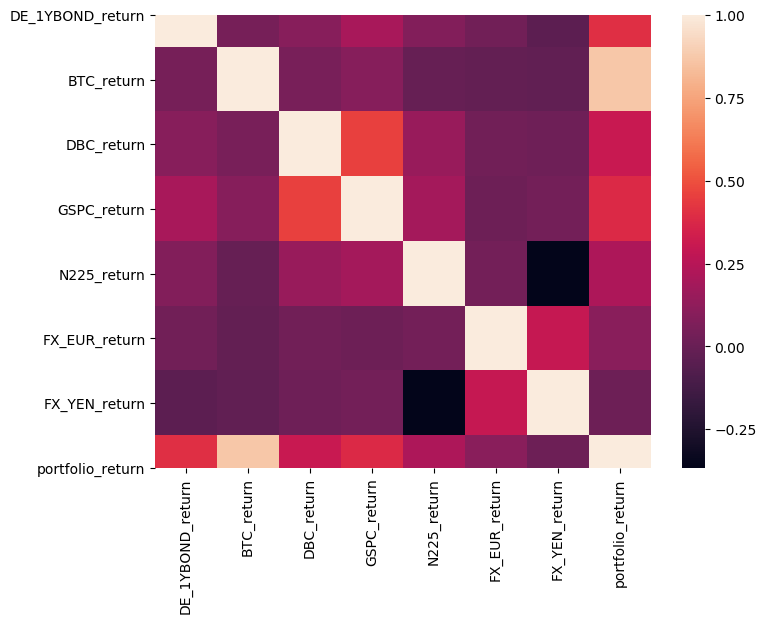

In [131]:
import seaborn as sns
plt.figure(figsize=(8,6),dpi=100)
corr = df_prices.corr()
sns.heatmap(corr)

In [124]:
asset = [DE_1YBOND_new,BTC_new, DBC_new, GSPC_new, N225_new, FX_EUR_new, FX_YEN_new]
data_last = pd.concat(asset, axis=1)

data_last.head()

,Date,Price_DE_1YBOND,Price_DE_1YBOND_lag,DE_1YBOND_return,DE_1YBOND_plus2perc_combined_return,DE_1YBOND_plus3perc_combined_return,DE_1YBOND_minus2perc_combined_return,DE_1YBOND_minus3perc_combined_return,Price_BTC,Price_BTC_lag,...,Price_FX_EUR,Price_FX_EUR_lag,FX_EUR_return,FX_EUR_plus10_combined_return,FX_EUR_minus10_combined_return,Price_FX_YEN,Price_FX_YEN_lag,FX_YEN_return,FX_YEN_plus10_combined_return,FX_YEN_minus10_combined_return
0,2011-03-31,1.209,NaN,NaN,NaN,NaN,NaN,NaN,0.7846,NaN,...,1.412130,NaN,NaN,NaN,NaN,0.012026,NaN,NaN,NaN,NaN
1,2011-04-01,1.306,1.209,0.097,0.097,0.097,0.097,0.097,0.7741,0.7846,...,1.415869,1.412130,0.002644,0.002644,0.002644,0.011996,0.012026,-0.002498,-0.002498,-0.002498
2,2011-04-04,1.292,1.306,-0.014,-0.014,-0.014,-0.014,-0.014,0.6800,0.7741,...,1.422333,1.415869,0.004555,0.004555,0.004555,0.011874,0.011996,-0.010222,-0.010222,-0.010222
3,2011-04-05,1.299,1.292,0.007,0.007,0.007,0.007,0.007,0.7100,0.6800,...,1.422010,1.422333,-0.000227,-0.000227,-0.000227,0.011886,0.011874,0.001010,0.001010,0.001010
4,2011-04-06,1.294,1.299,-0.005,-0.005,-0.005,-0.005,-0.005,0.7400,0.7100,...,1.421909,1.422010,-0.000071,-0.000071,-0.000071,0.011743,0.011886,-0.012104,-0.012104,-0.012104


In [130]:
#store the data 

Assetprice = data_last[['Price_DE_1YBOND','Price_BTC','Price_DBC','Price_GSPC','Price_N225','Price_FX_EUR','Price_FX_YEN']]
Assetprice = Assetprice.set_index(pd.to_datetime(data_last["Date"]))
Assetprice.to_csv("01_Data/AssetPriceData.csv", index_label= "Date")